In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from causalinference import CausalModel
from sklearn.linear_model import LogisticRegression
import pandas as pd
from scipy.spatial.distance import cdist
import graphviz as gr
import scipy.stats as stats
from tqdm import tqdm

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

## 데이터 가져오기

In [2]:
data = pd.read_csv("to_psm_data.csv", index_col=0)

## 회귀 분석

##################################START##################################
Treat: 부동산여부_treat
model fit...
matching...


3526it [00:25, 139.24it/s]


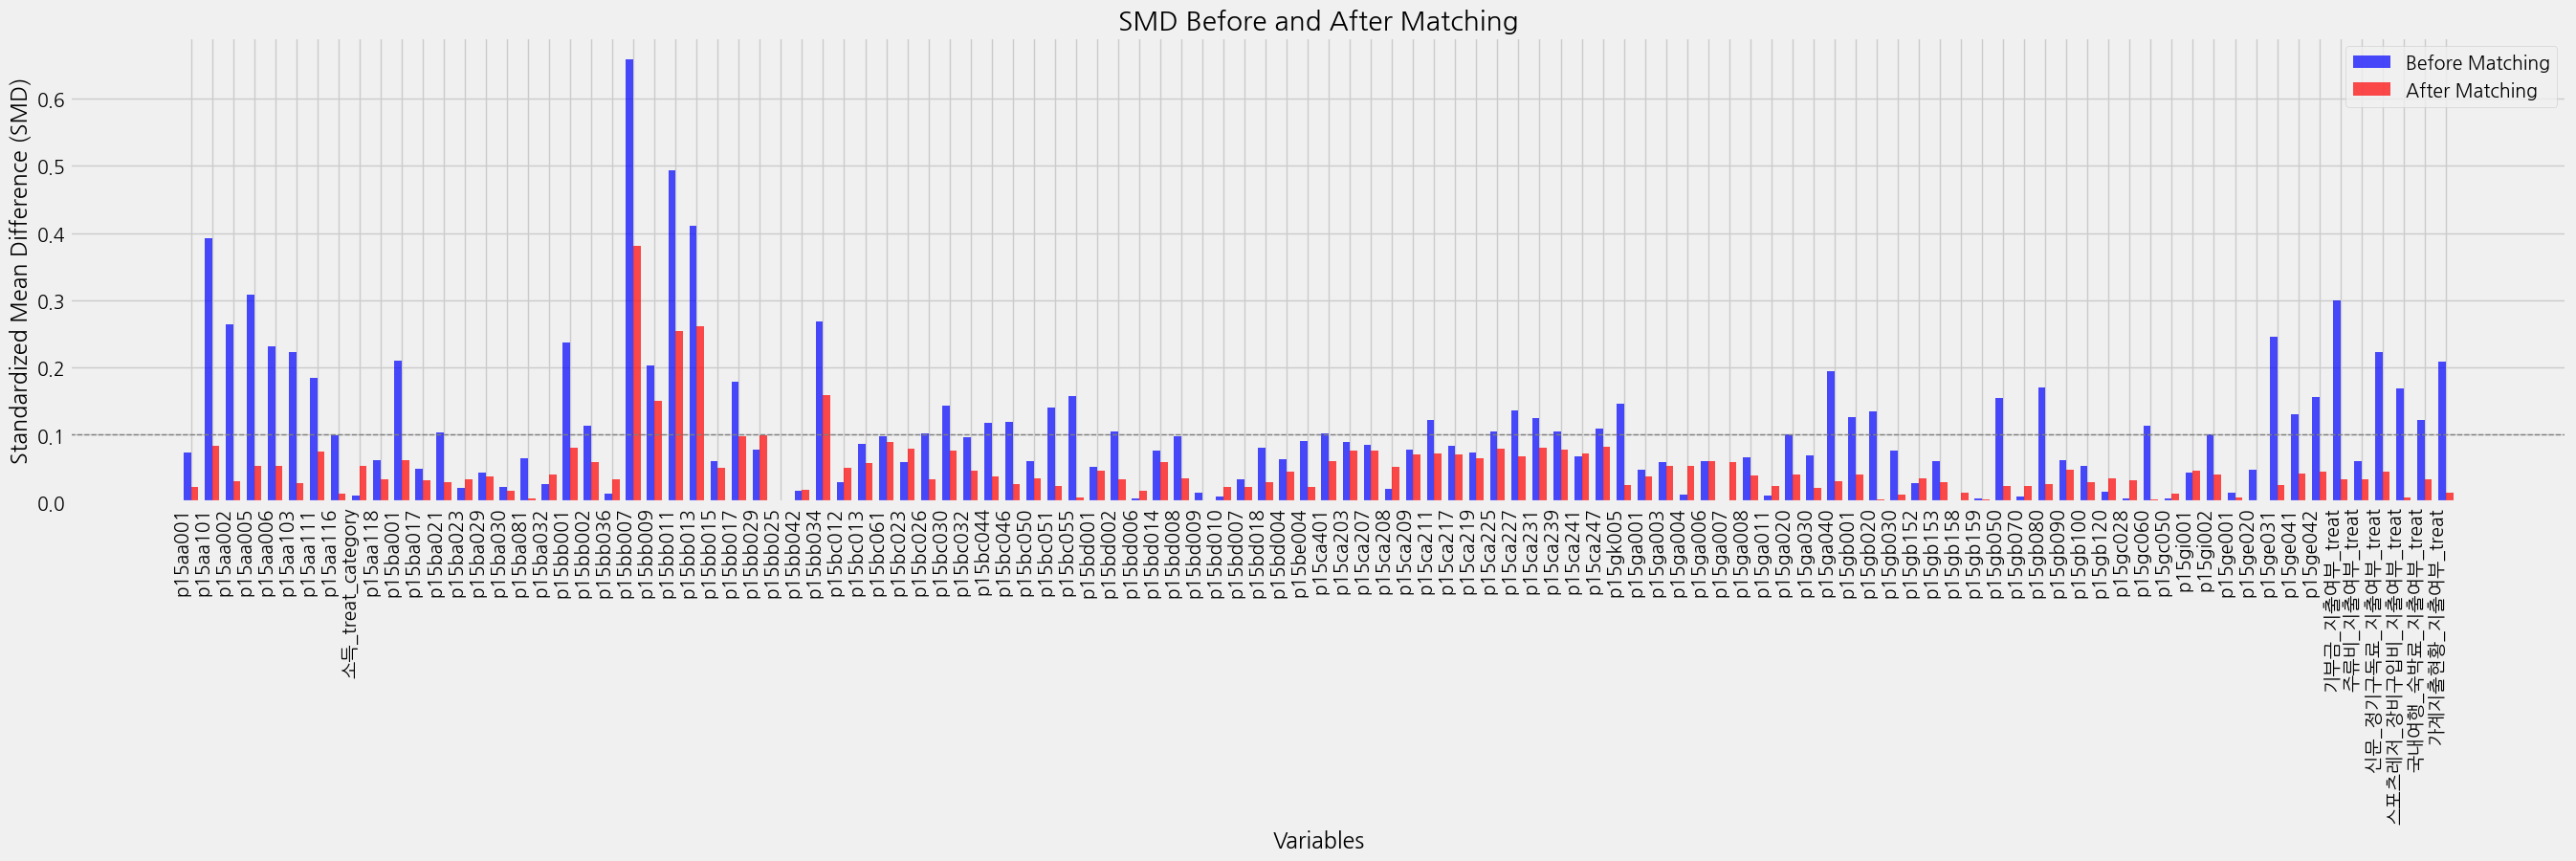

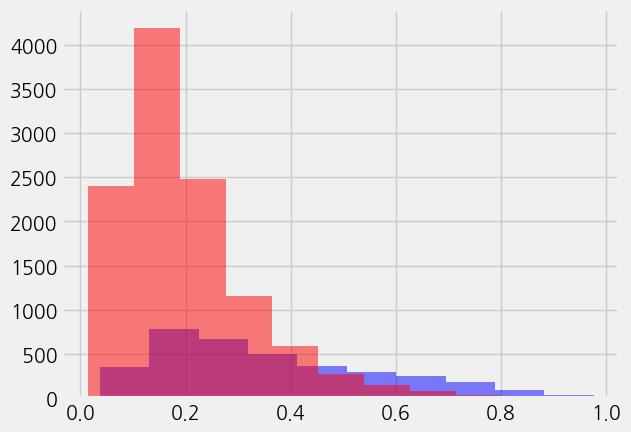

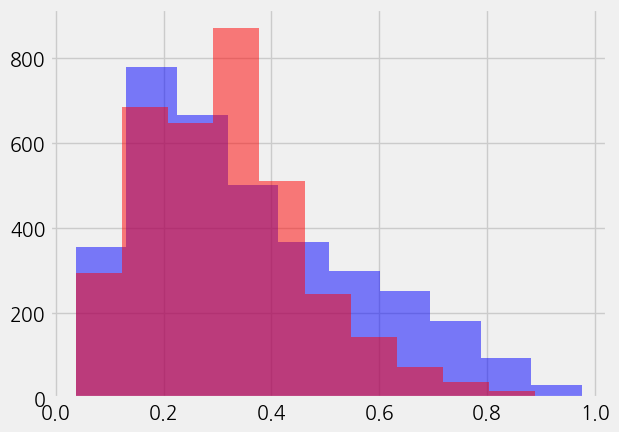

t-statistic: 1.9366080010946245
p-value: 0.052833189756752025
treat_group mean: 6.533465683494044
control_group mean: 6.4463981849120815
###################################END###################################

##################################START##################################
Treat: 신혼집여부_treat
model fit...
matching...


47it [00:00, 87.08it/s]


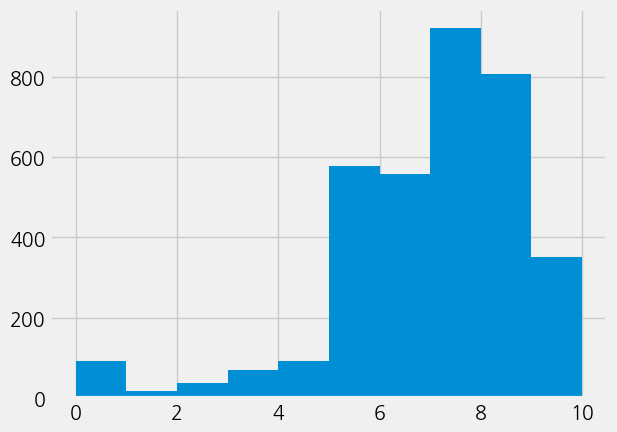

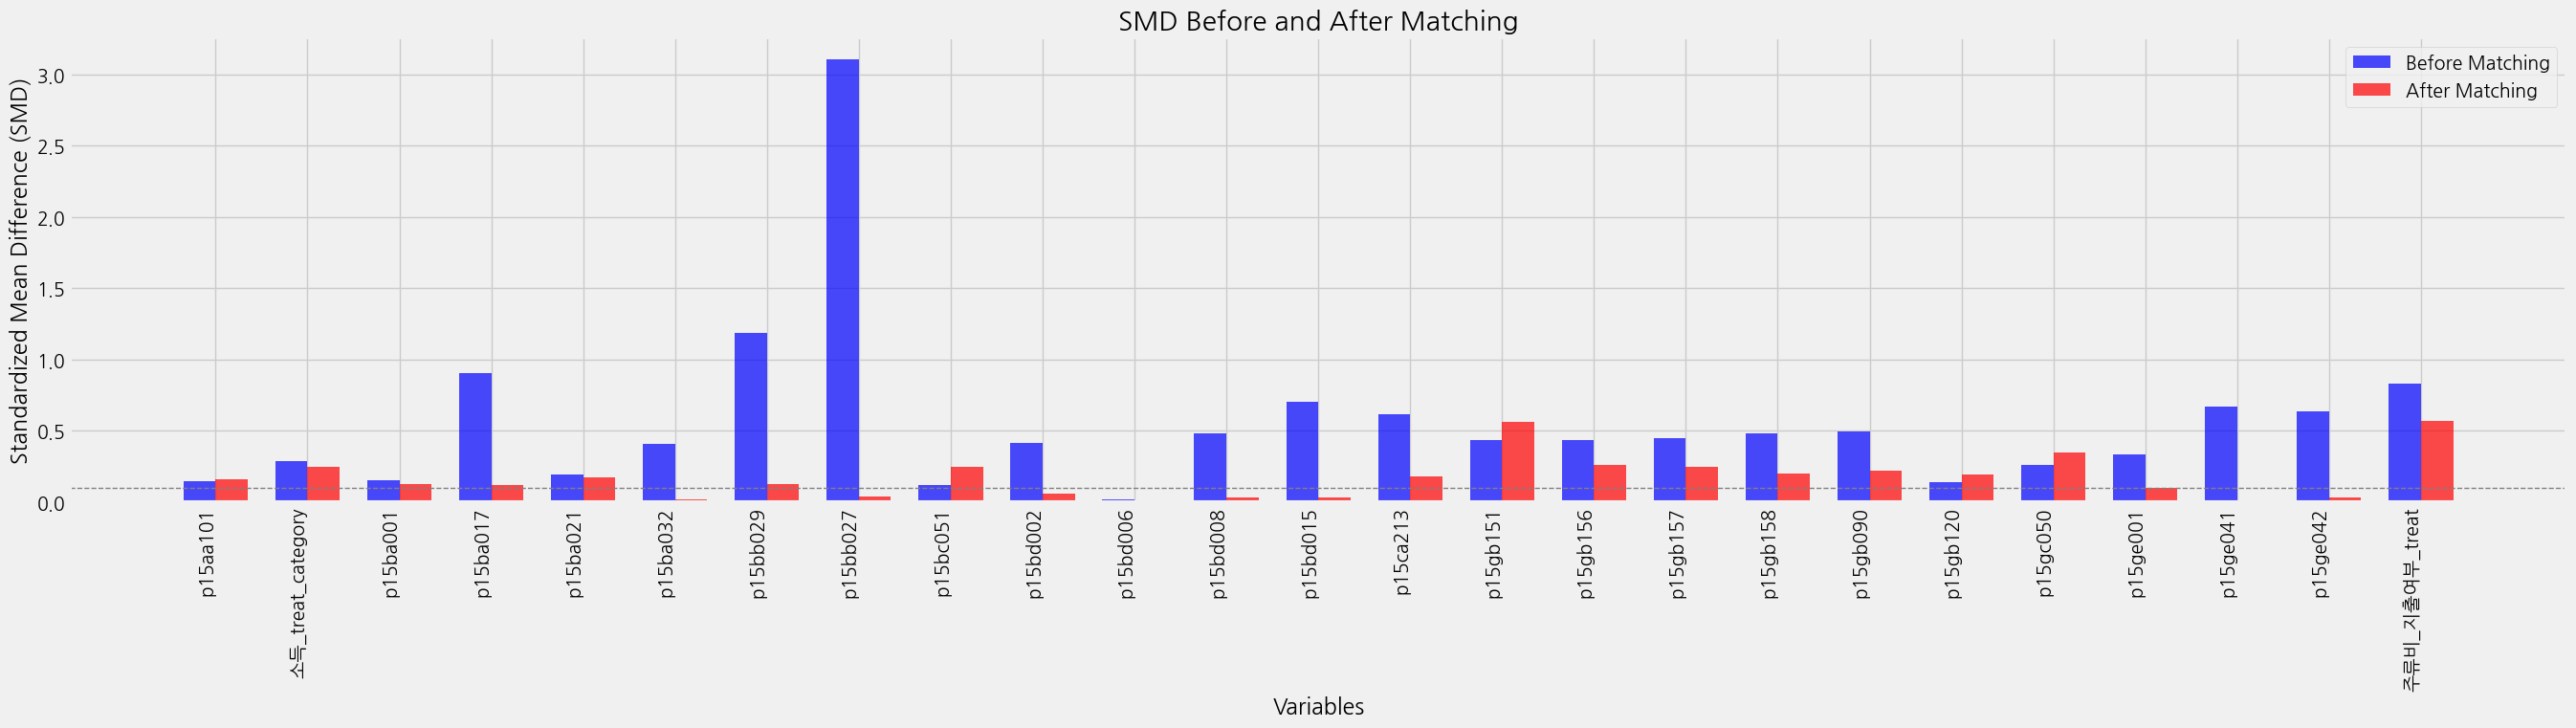

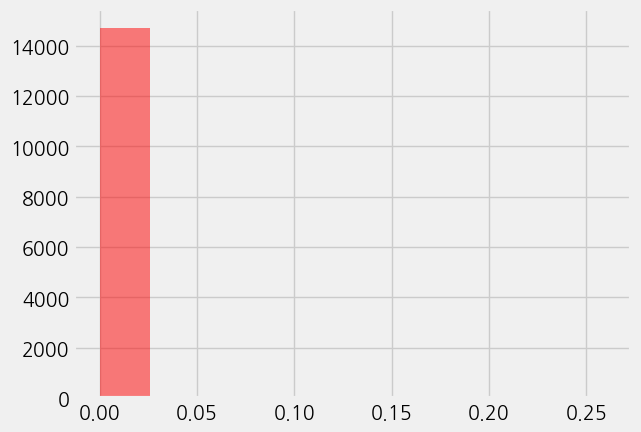

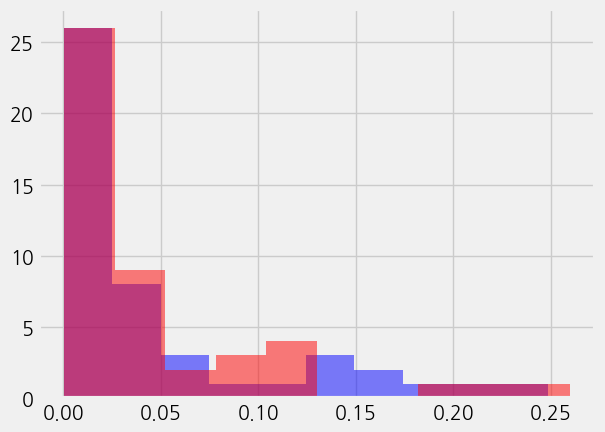

t-statistic: 0.7404177278886945
p-value: 0.4609320266656526
treat_group mean: 7.148936170212766
control_group mean: 6.851063829787234
###################################END###################################

##################################START##################################
Treat: 기부금_지출여부_treat
model fit...
matching...


4240it [00:27, 154.74it/s]


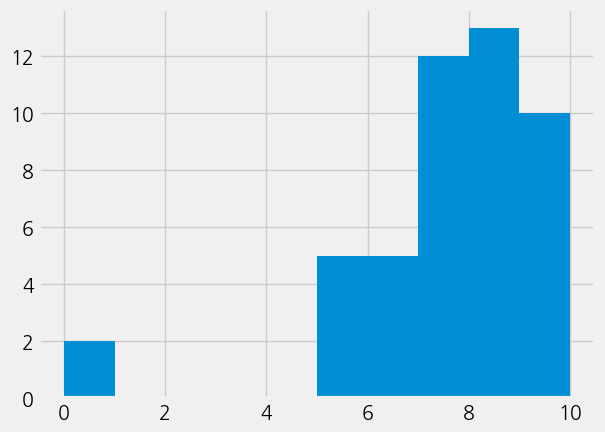

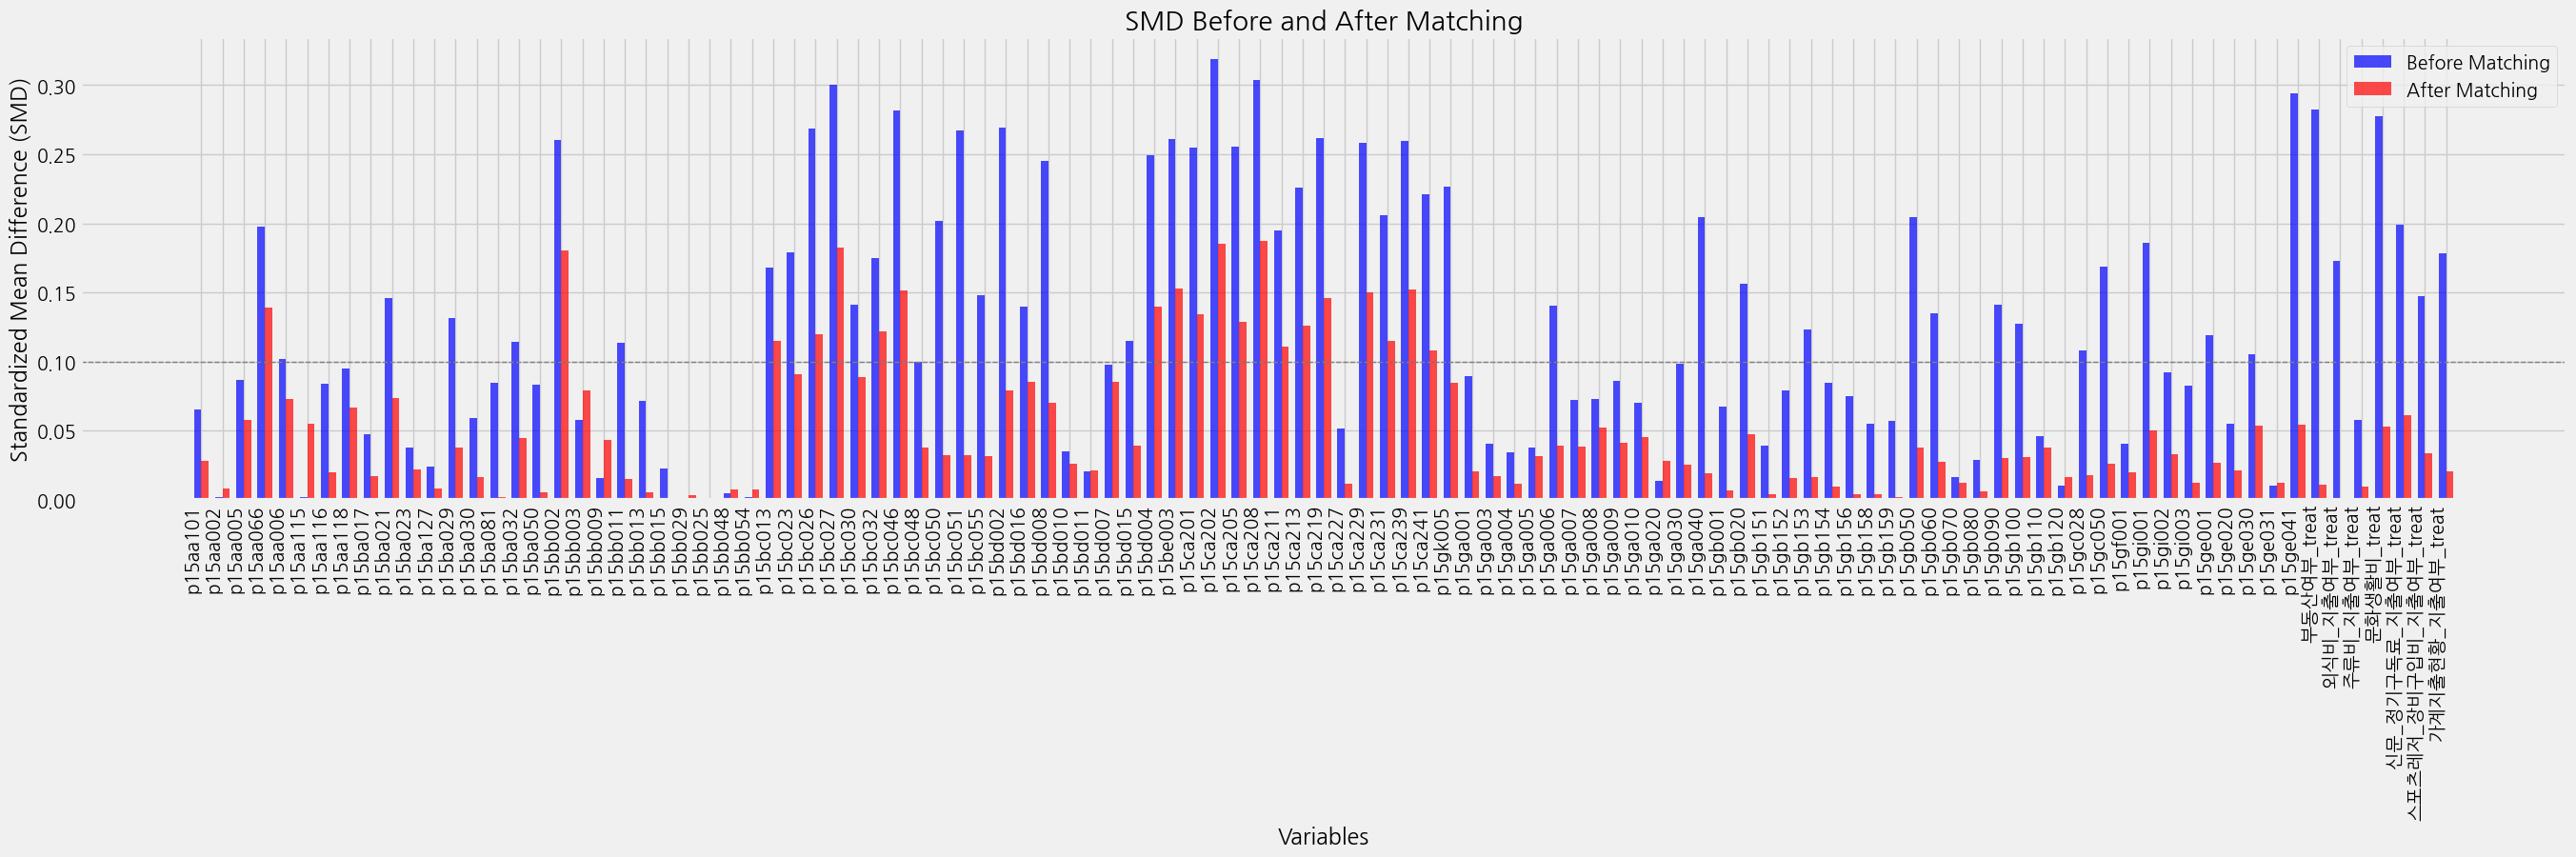

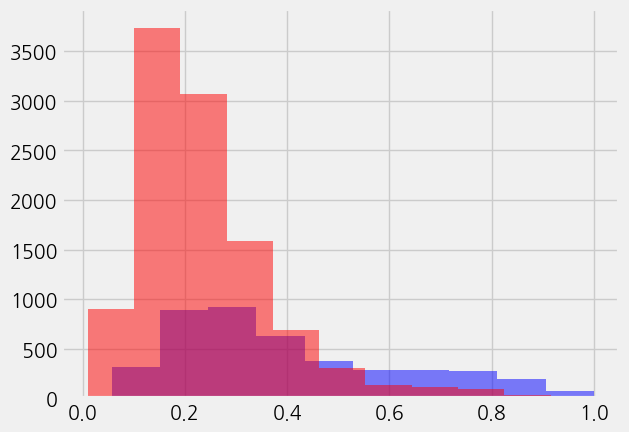

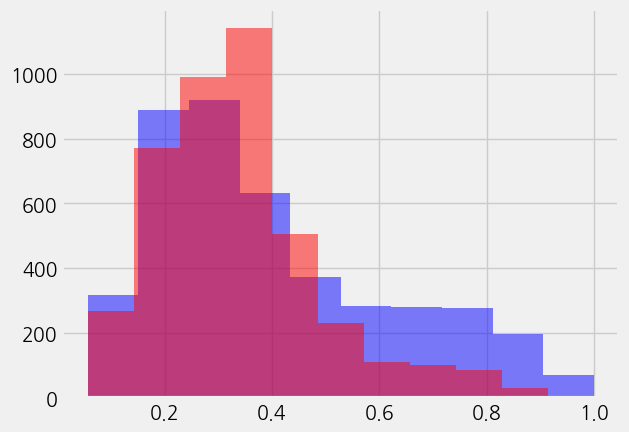

t-statistic: 3.4868424133839113
p-value: 0.0004912356341514321
treat_group mean: 6.598584905660378
control_group mean: 6.457075471698113
###################################END###################################

##################################START##################################
Treat: 외식비_지출여부_treat
model fit...
matching...


1350it [00:12, 104.76it/s]


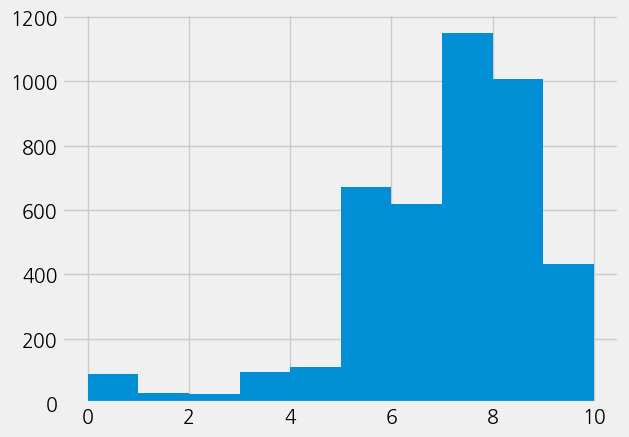

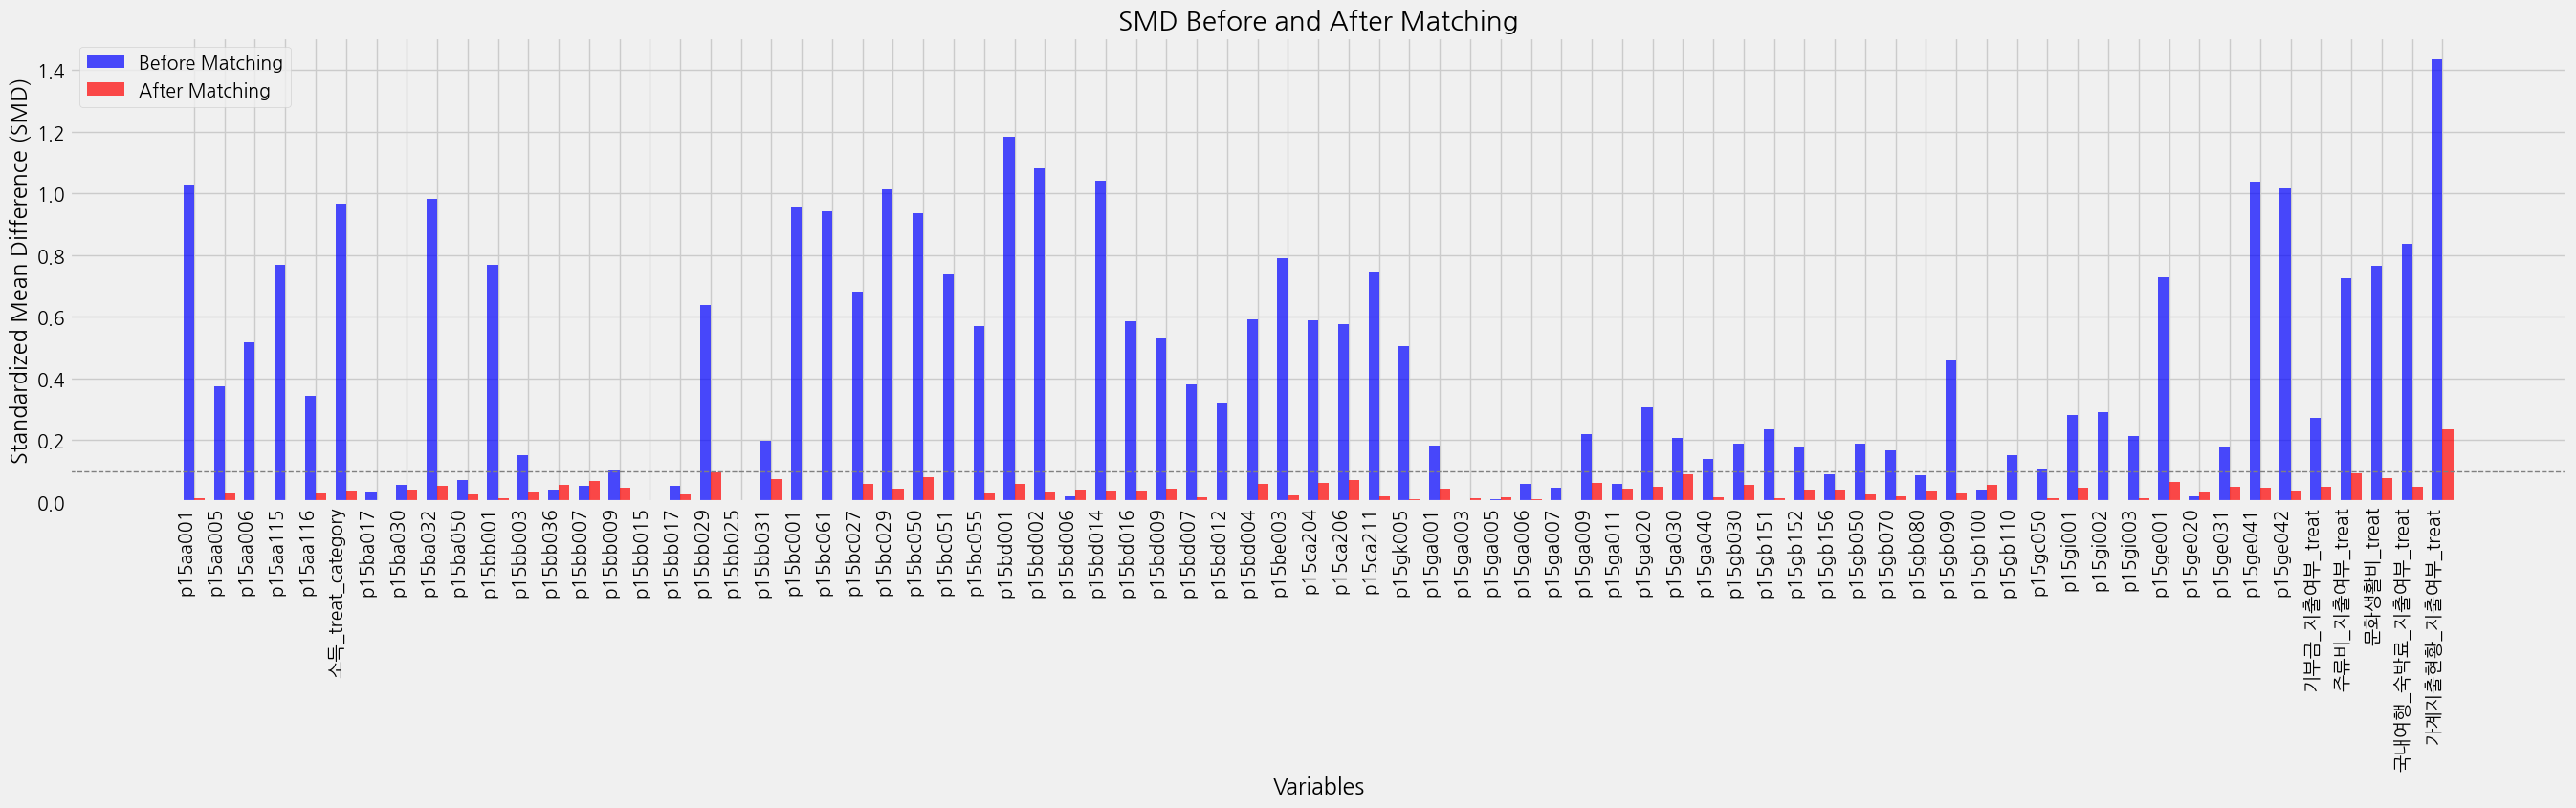

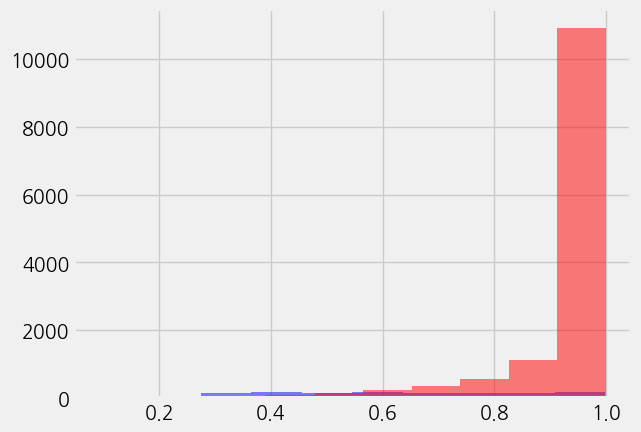

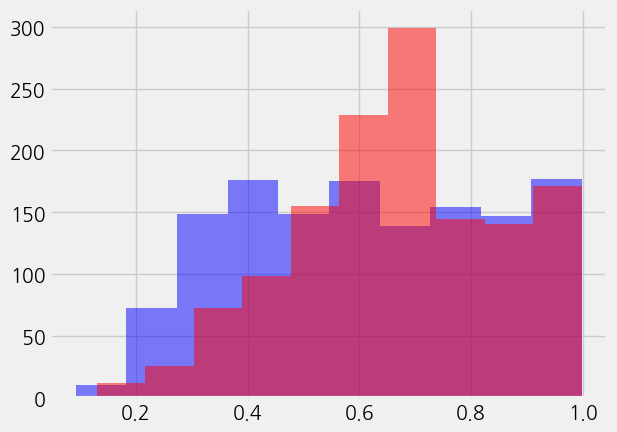

t-statistic: -0.0722134197417961
p-value: 0.9424374182170383
treat_group mean: 5.5814814814814815
control_group mean: 5.587407407407407
###################################END###################################

##################################START##################################
Treat: 주류비_지출여부_treat
model fit...
matching...


6546it [00:17, 374.35it/s] 


ERROR!!!!!!
##################################START##################################
Treat: 문화생활비_treat
model fit...
matching...


5461it [00:29, 183.30it/s]


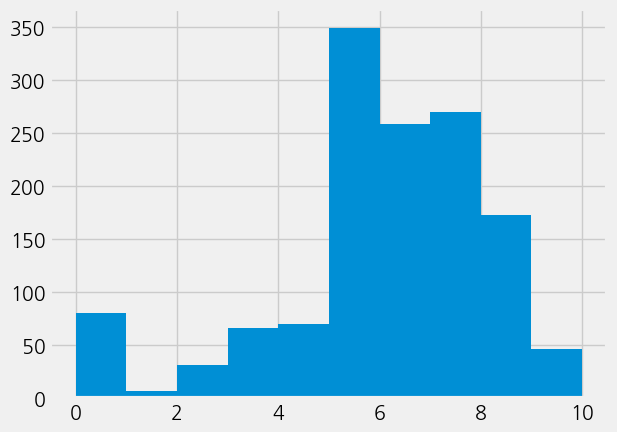

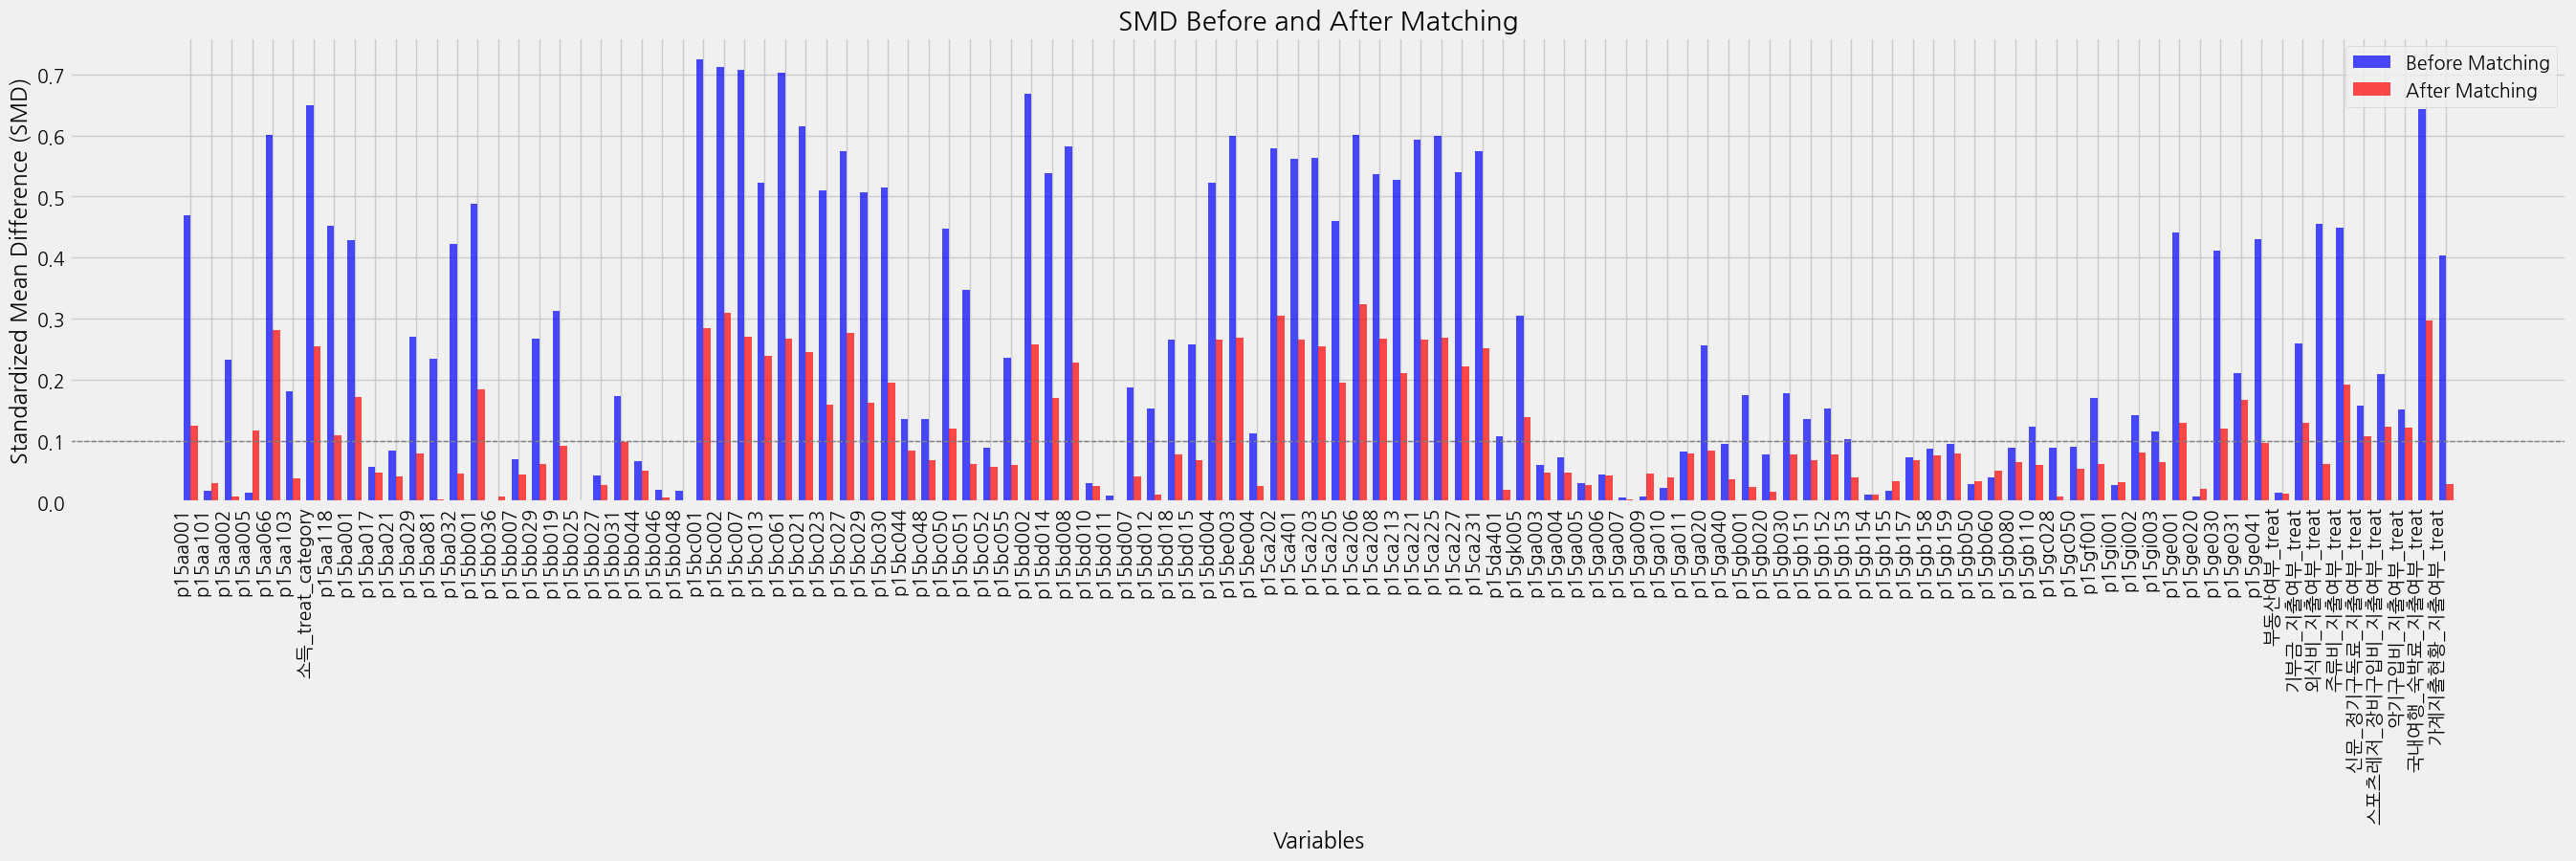

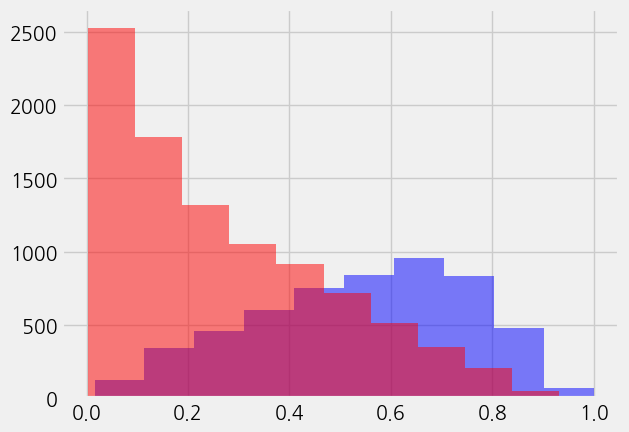

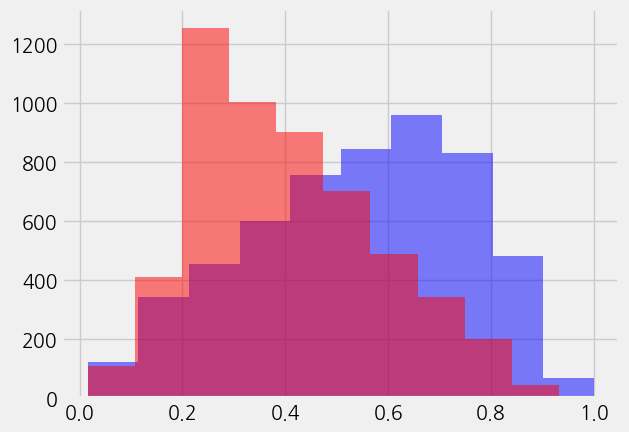

t-statistic: 5.10499876721516
p-value: 3.363668945179184e-07
treat_group mean: 6.658304339864494
control_group mean: 6.479948727339315
###################################END###################################

##################################START##################################
Treat: 신문_정기구독료_지출여부_treat
model fit...
matching...


382it [00:04, 89.56it/s] 


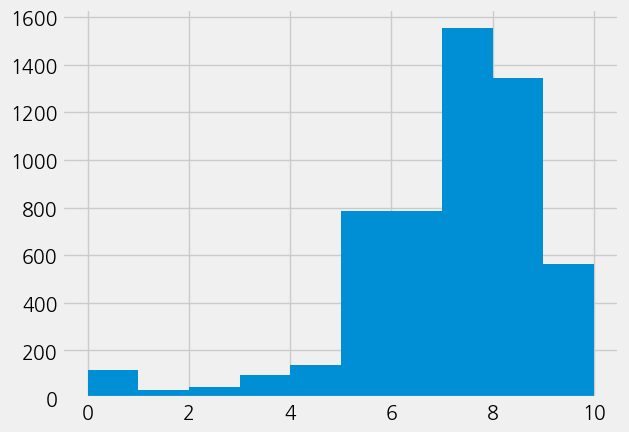

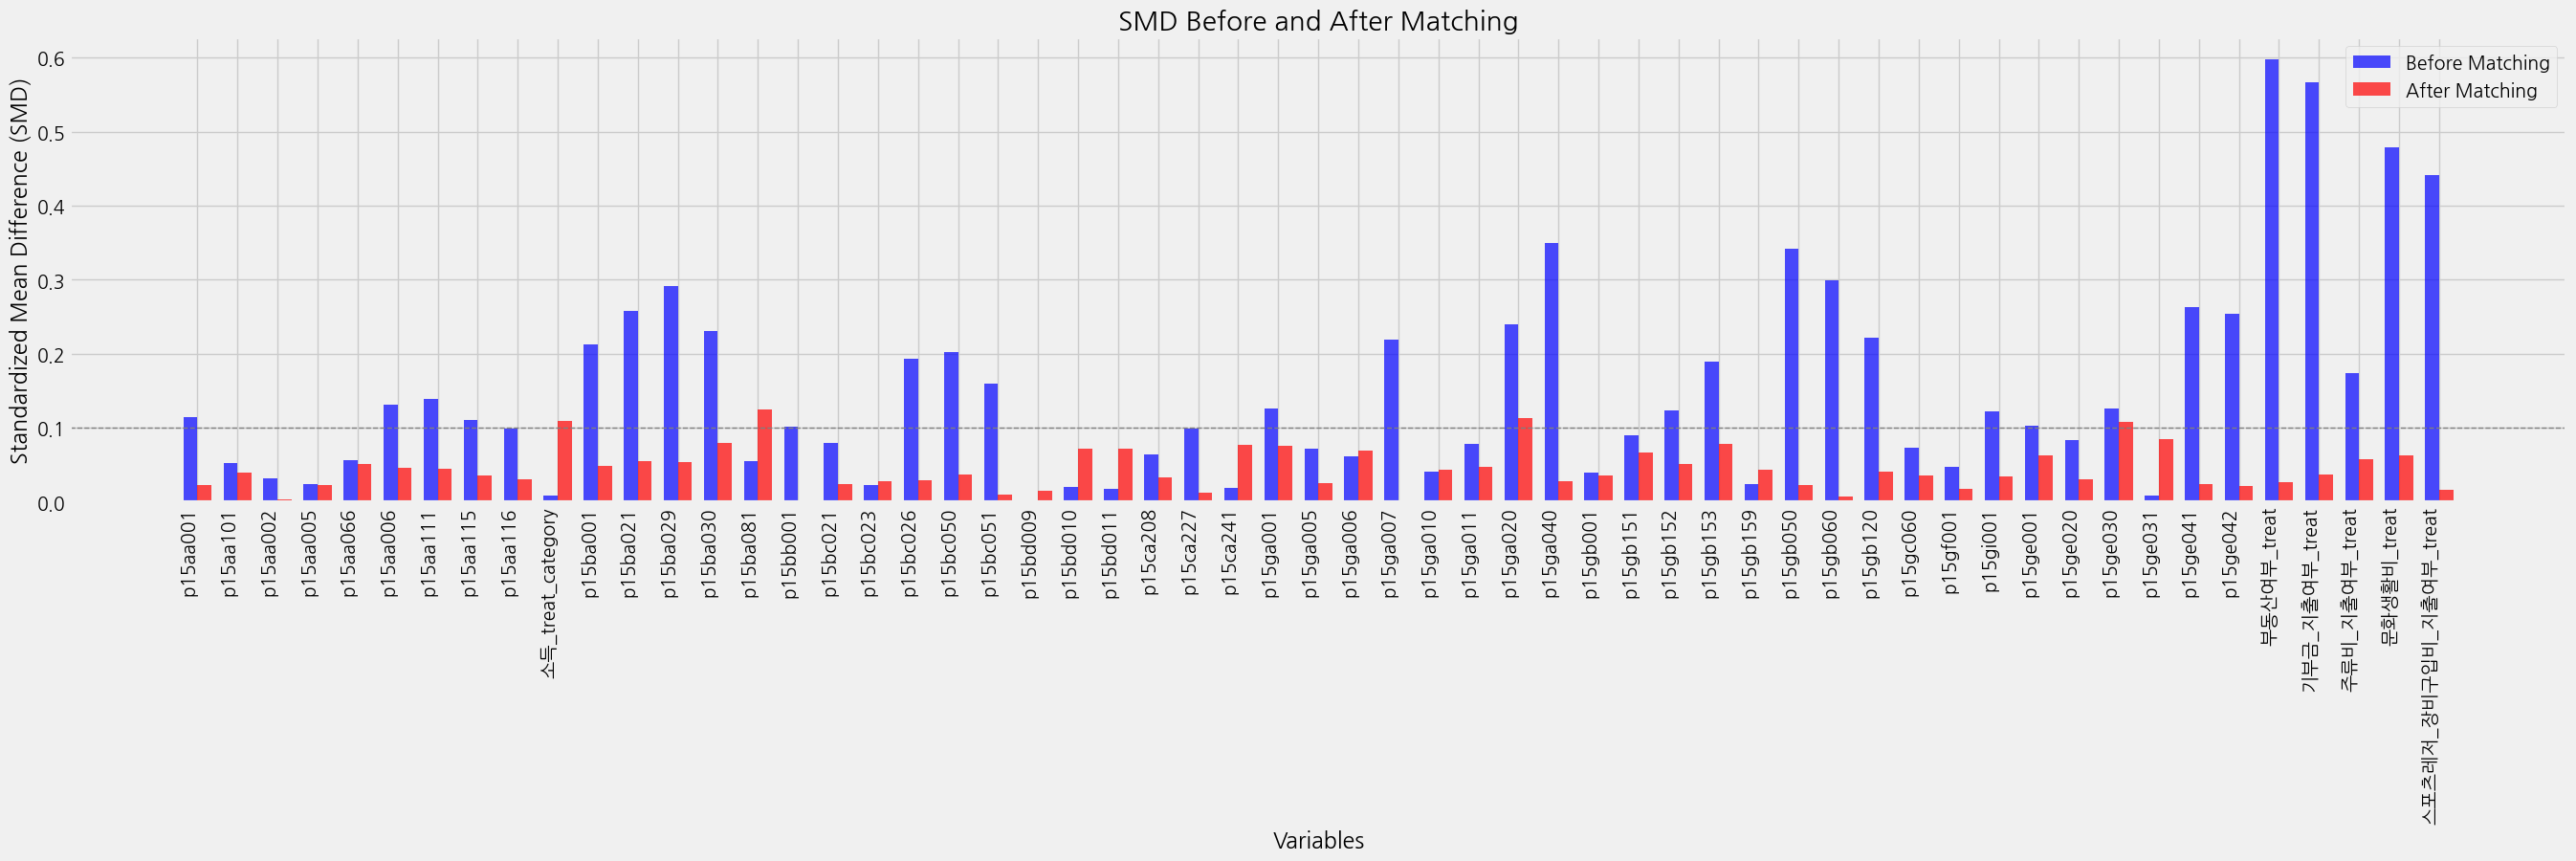

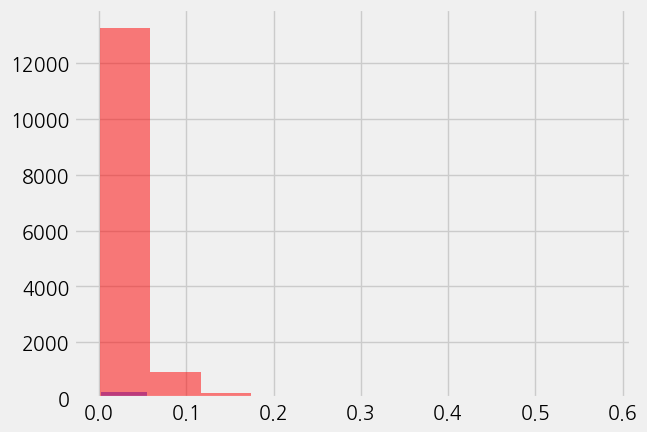

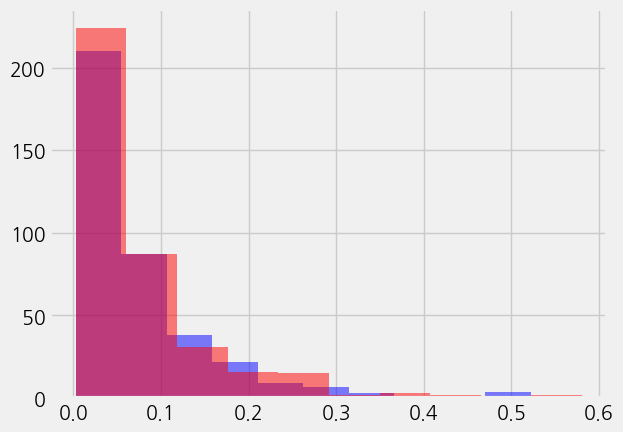

t-statistic: -2.044861528704735
p-value: 0.041211581047059444
treat_group mean: 6.505235602094241
control_group mean: 6.793193717277487
###################################END###################################

##################################START##################################
Treat: 스포츠레저_장비구입비_지출여부_treat
model fit...
matching...


567it [00:05, 97.45it/s] 


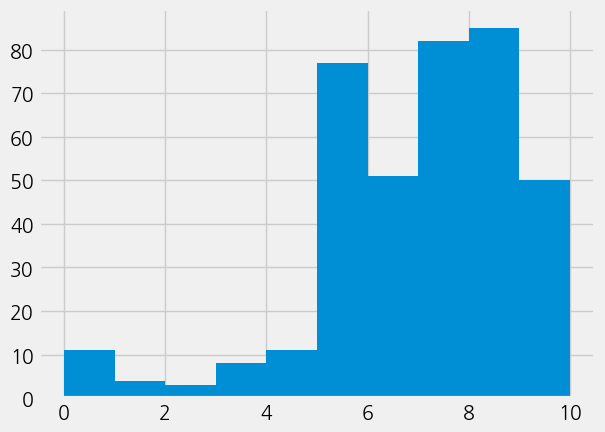

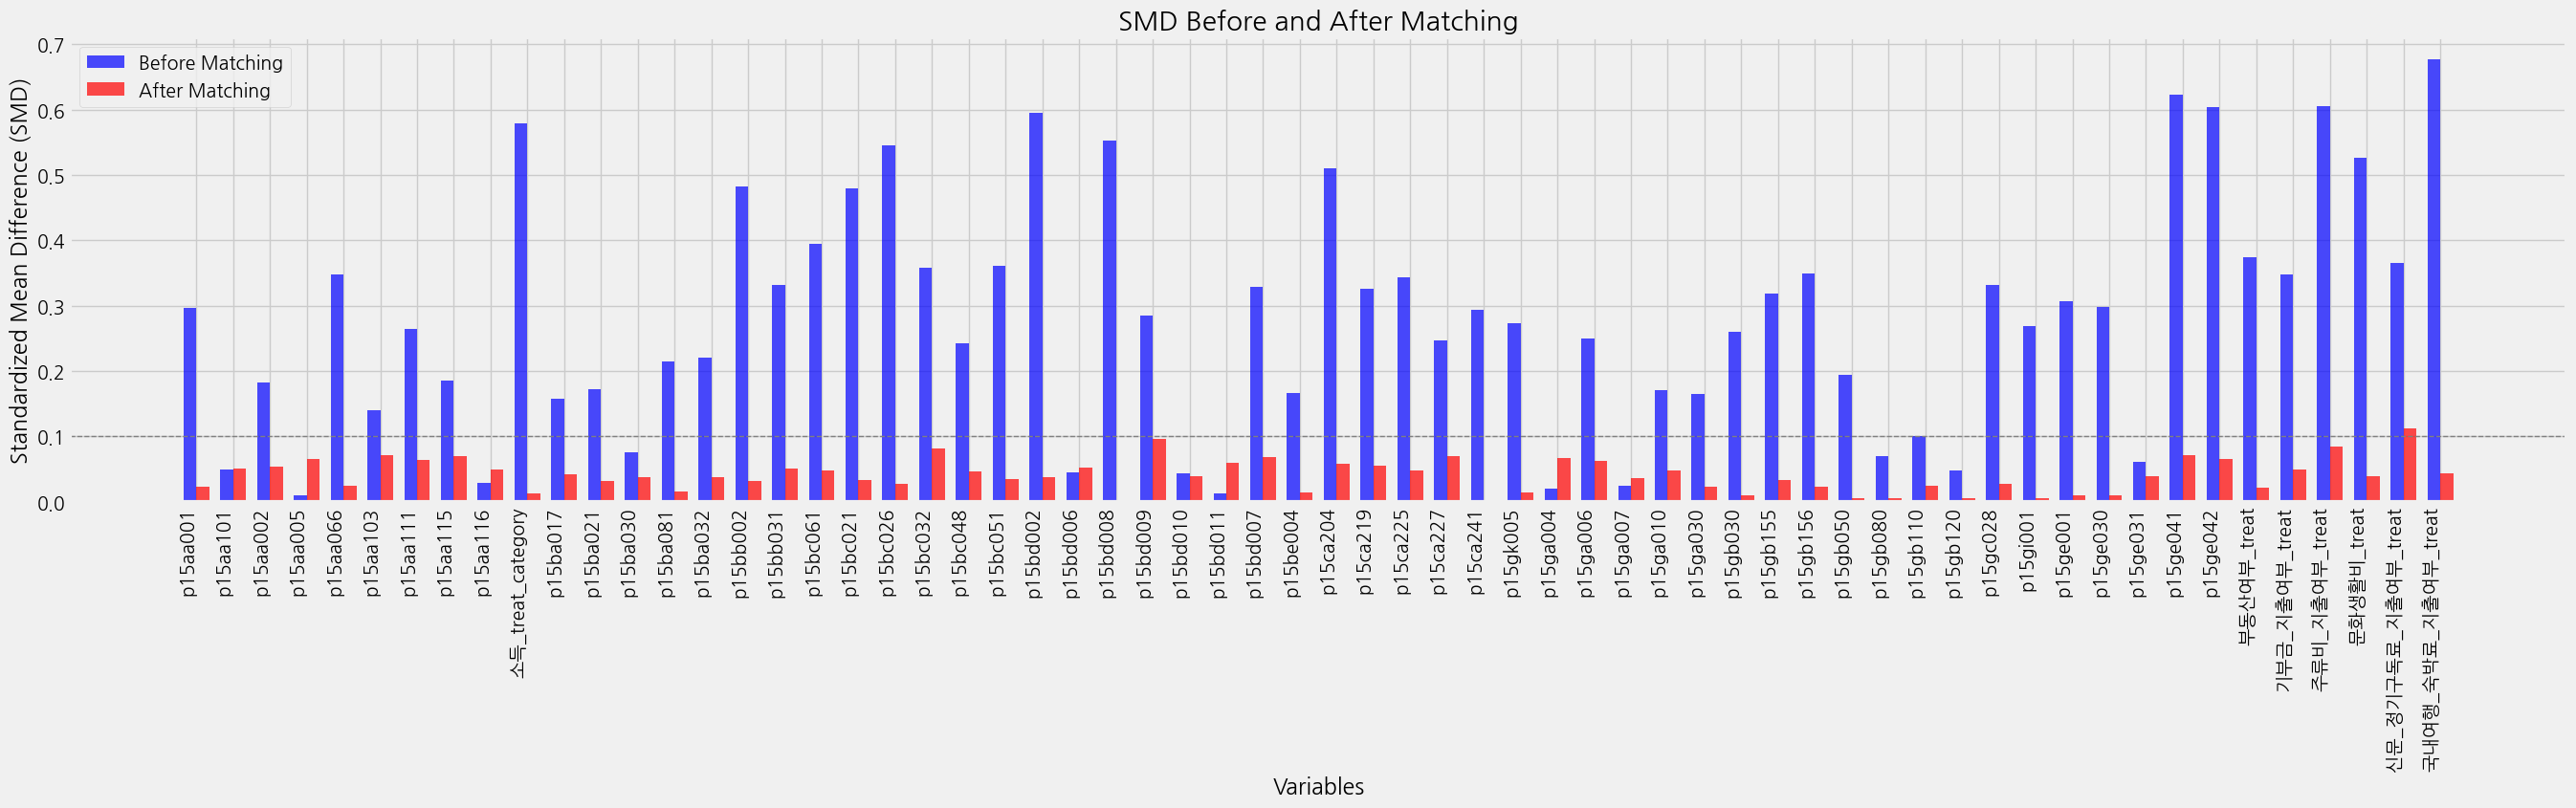

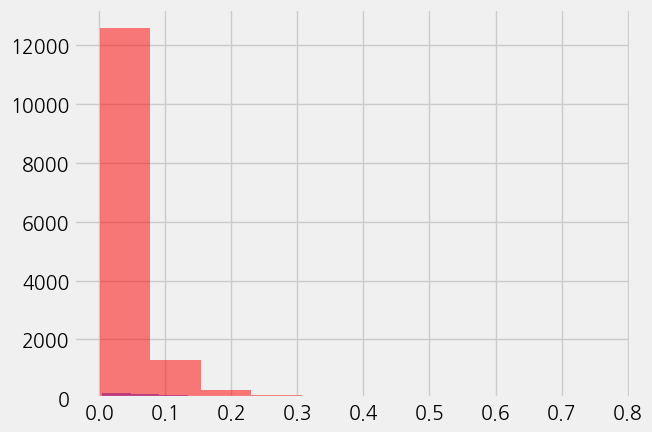

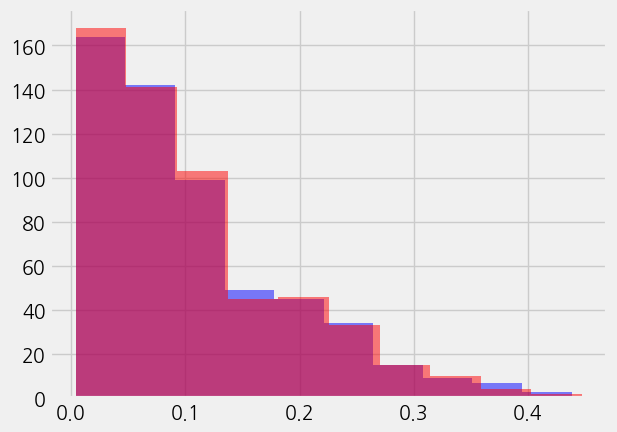

t-statistic: 0.30130573702631097
p-value: 0.7632367034959602
treat_group mean: 6.873015873015873
control_group mean: 6.841269841269841
###################################END###################################

##################################START##################################
Treat: 악기구입비_지출여부_treat
model fit...
matching...


89it [00:01, 77.91it/s]


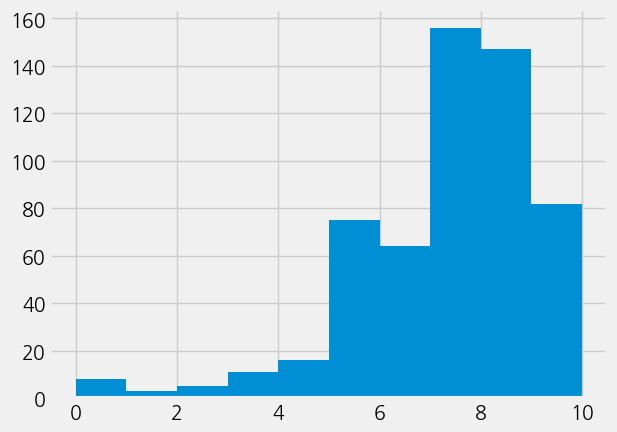

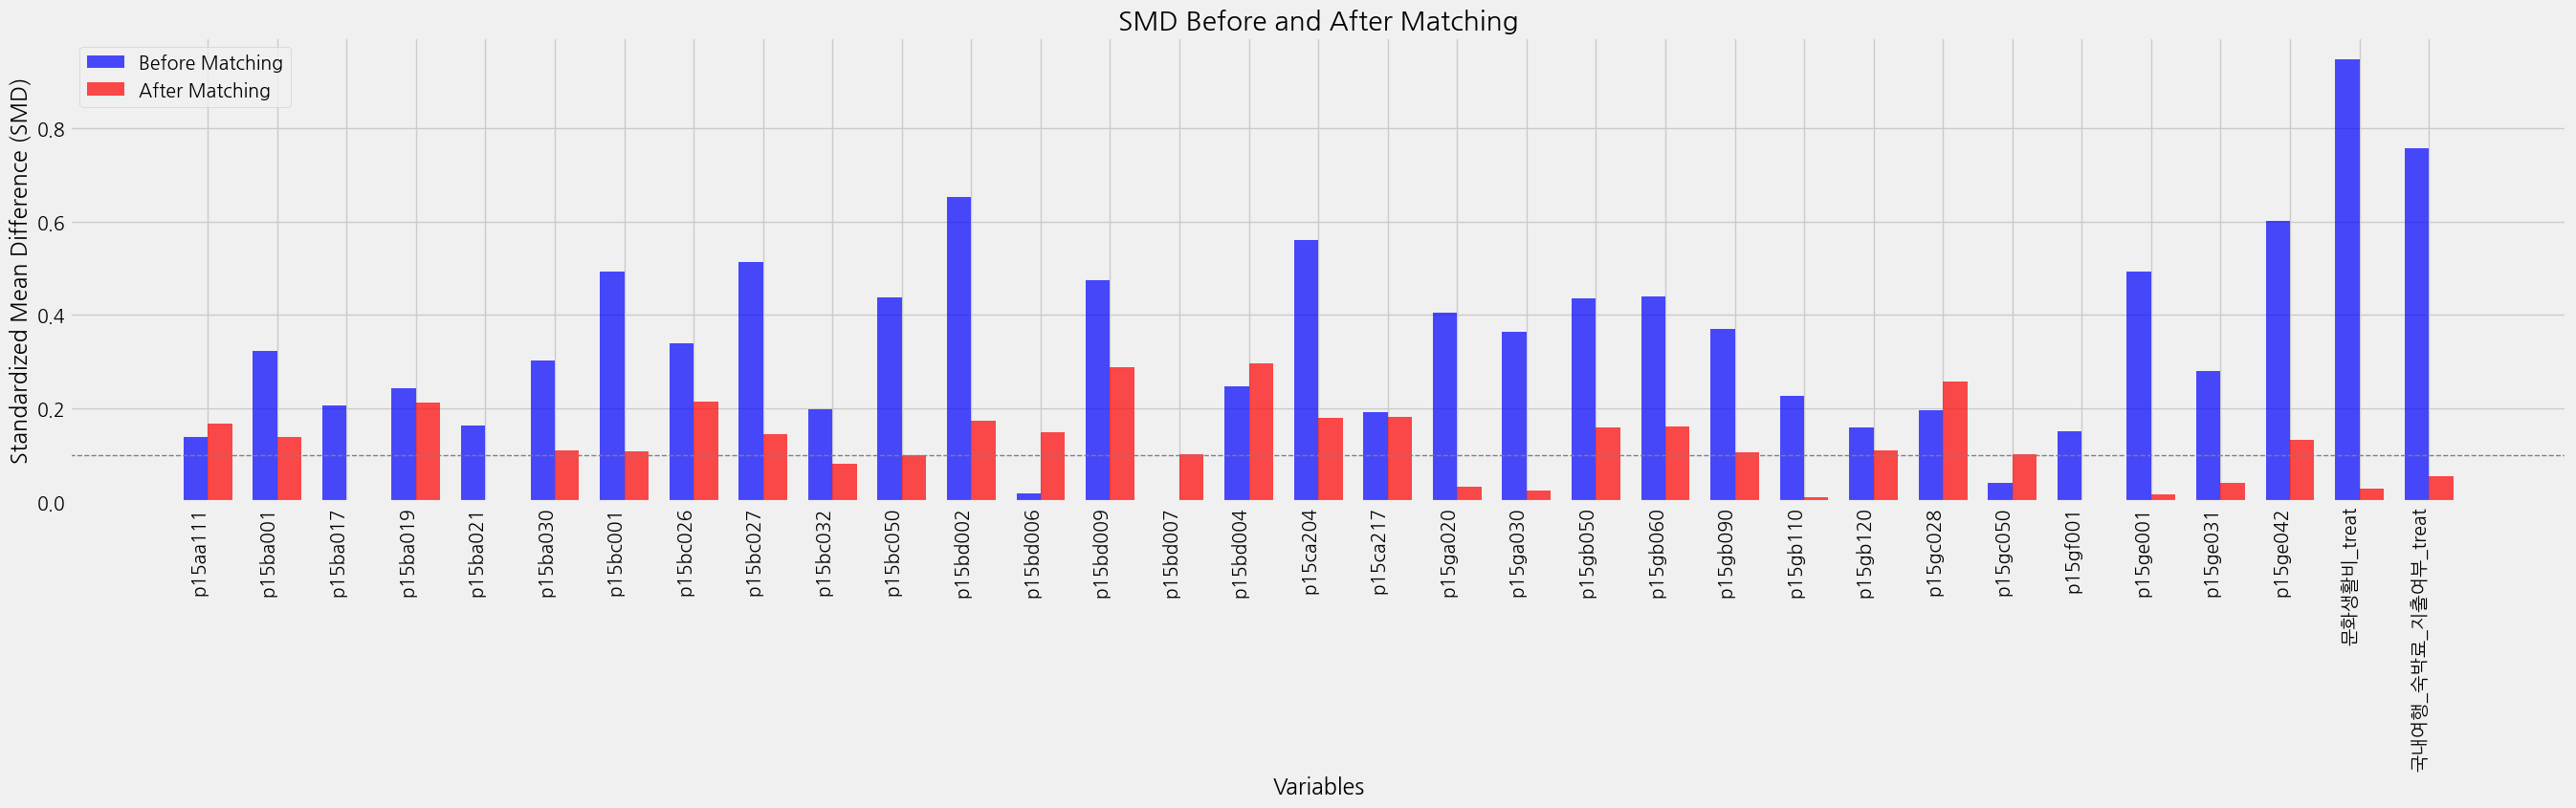

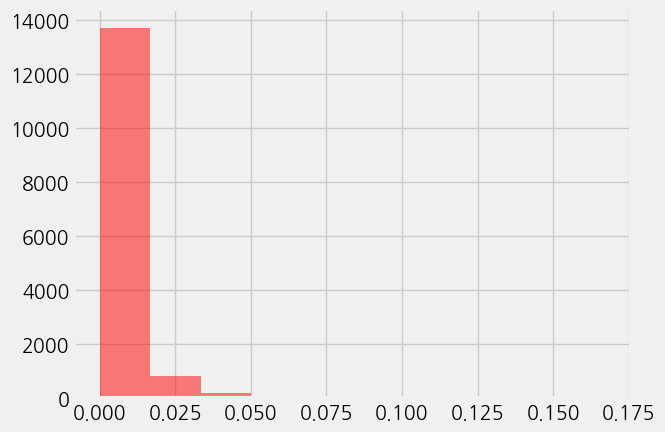

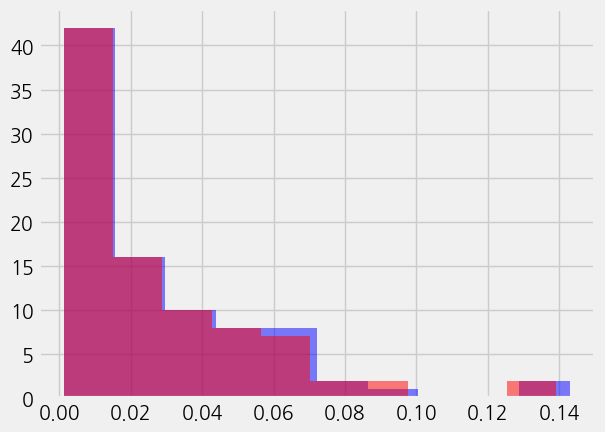

t-statistic: -0.4118482277015281
p-value: 0.680951810870139
treat_group mean: 6.808988764044944
control_group mean: 6.932584269662922
###################################END###################################

##################################START##################################
Treat: 국내여행_숙박료_지출여부_treat
model fit...
matching...


6344it [00:29, 216.21it/s]


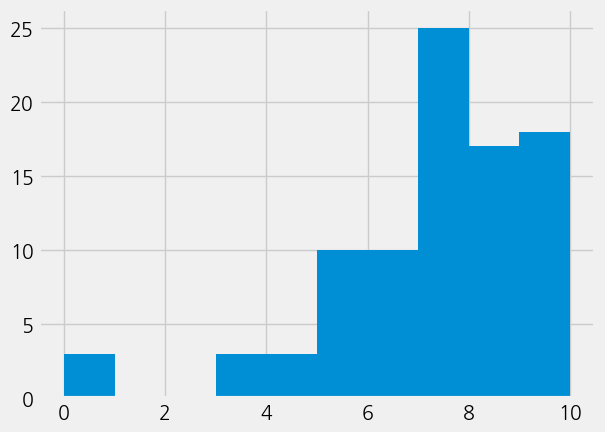

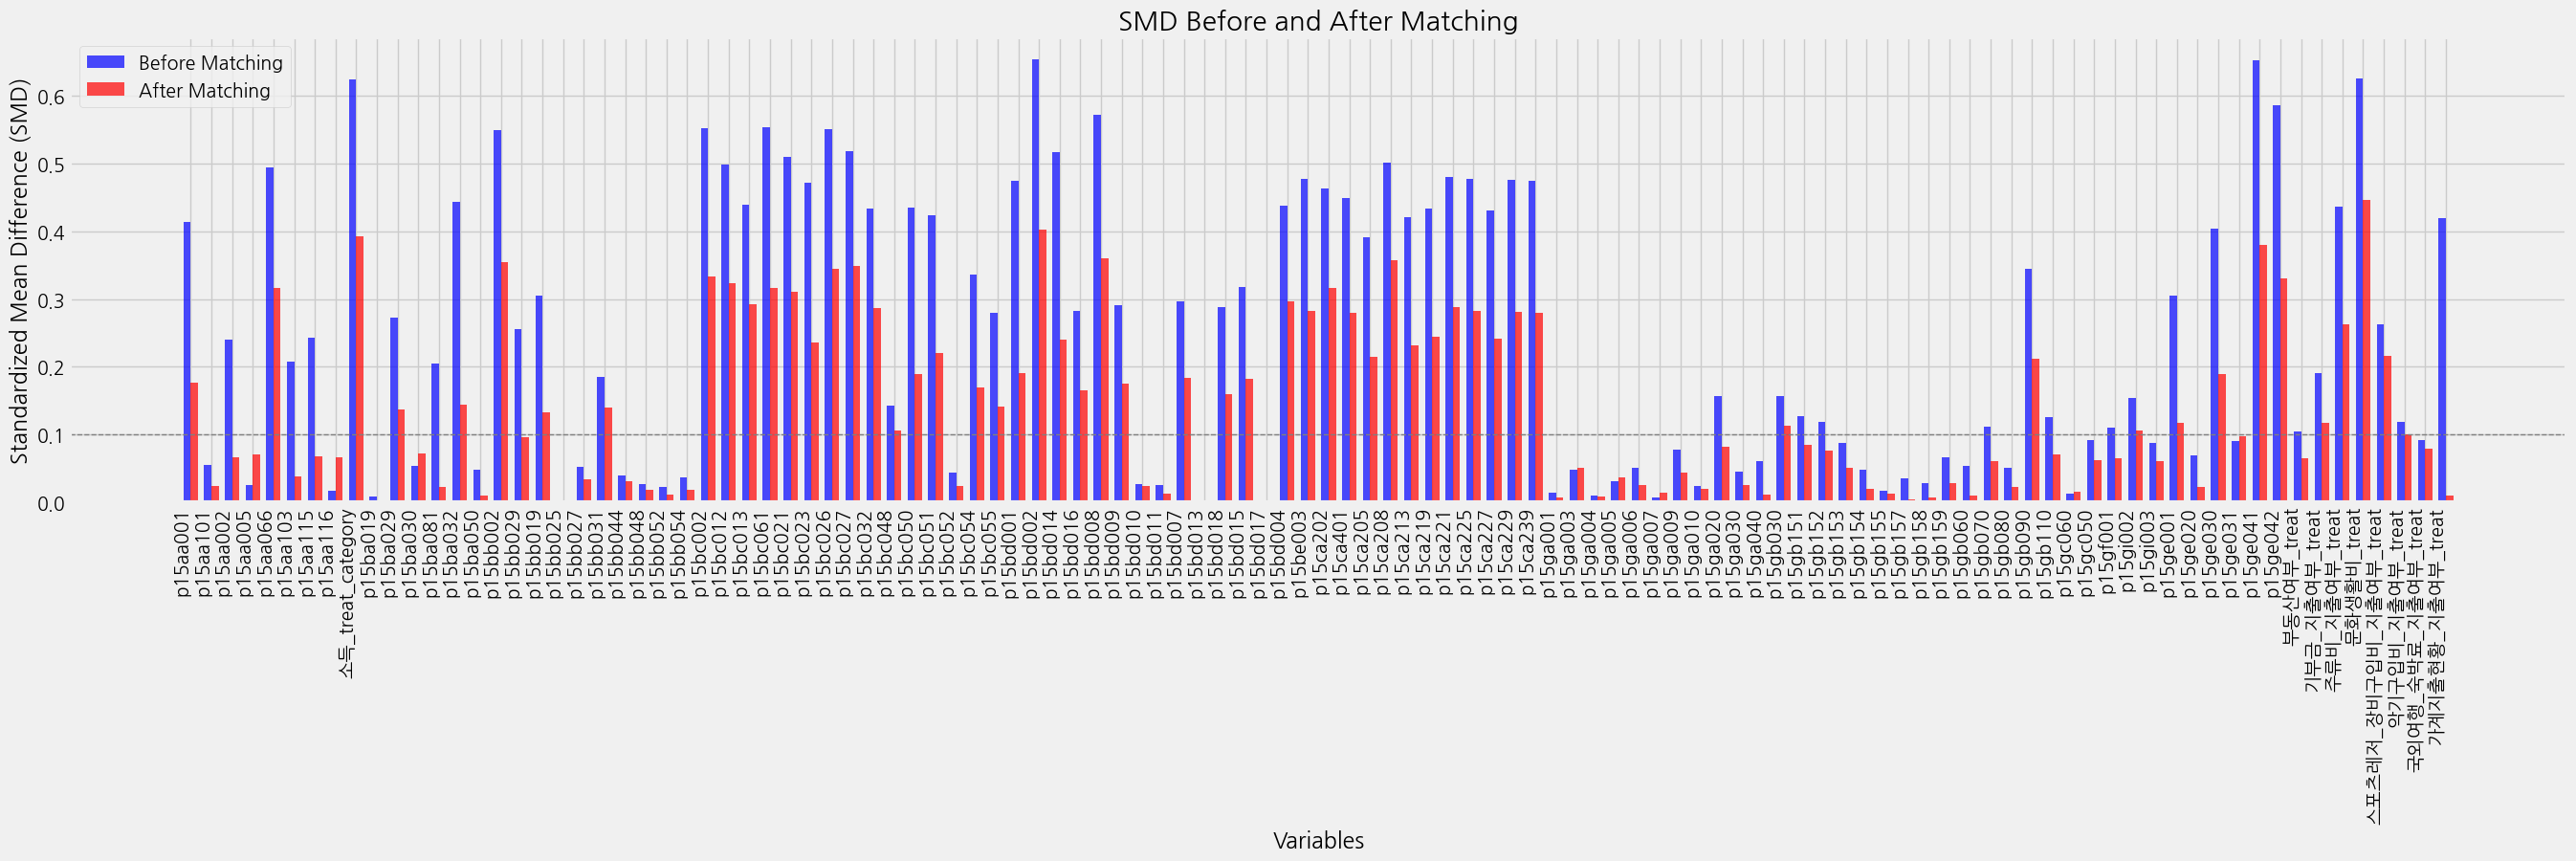

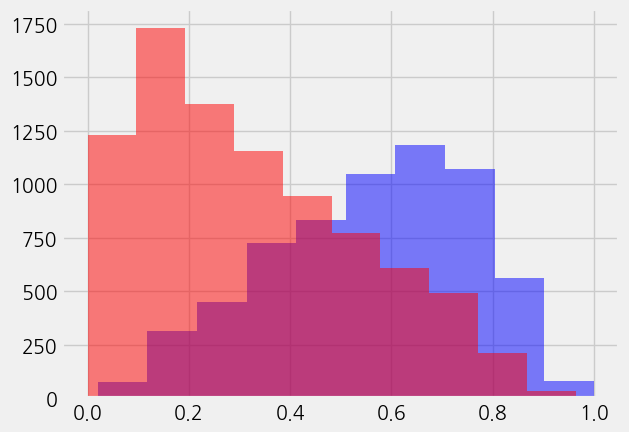

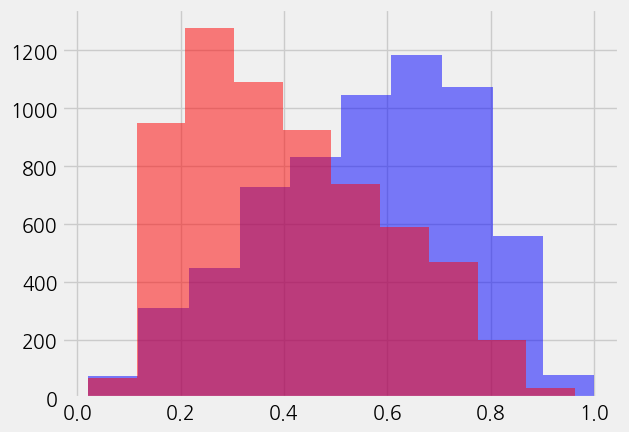

t-statistic: 9.761810182344387
p-value: 1.9693163550132594e-22
treat_group mean: 6.680012610340479
control_group mean: 6.370428751576292
###################################END###################################

##################################START##################################
Treat: 국외여행_숙박료_지출여부_treat
model fit...
matching...


49it [00:00, 60.43it/s]


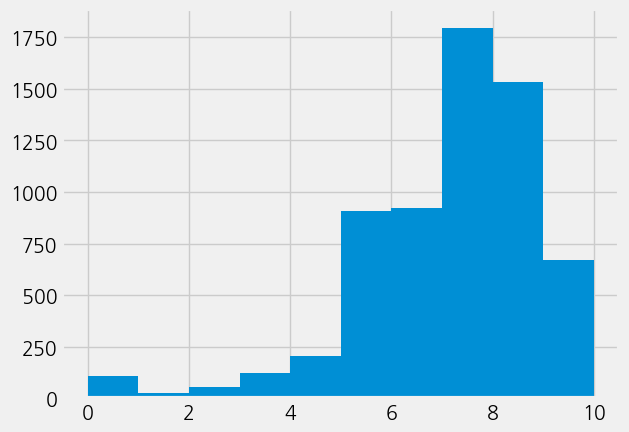

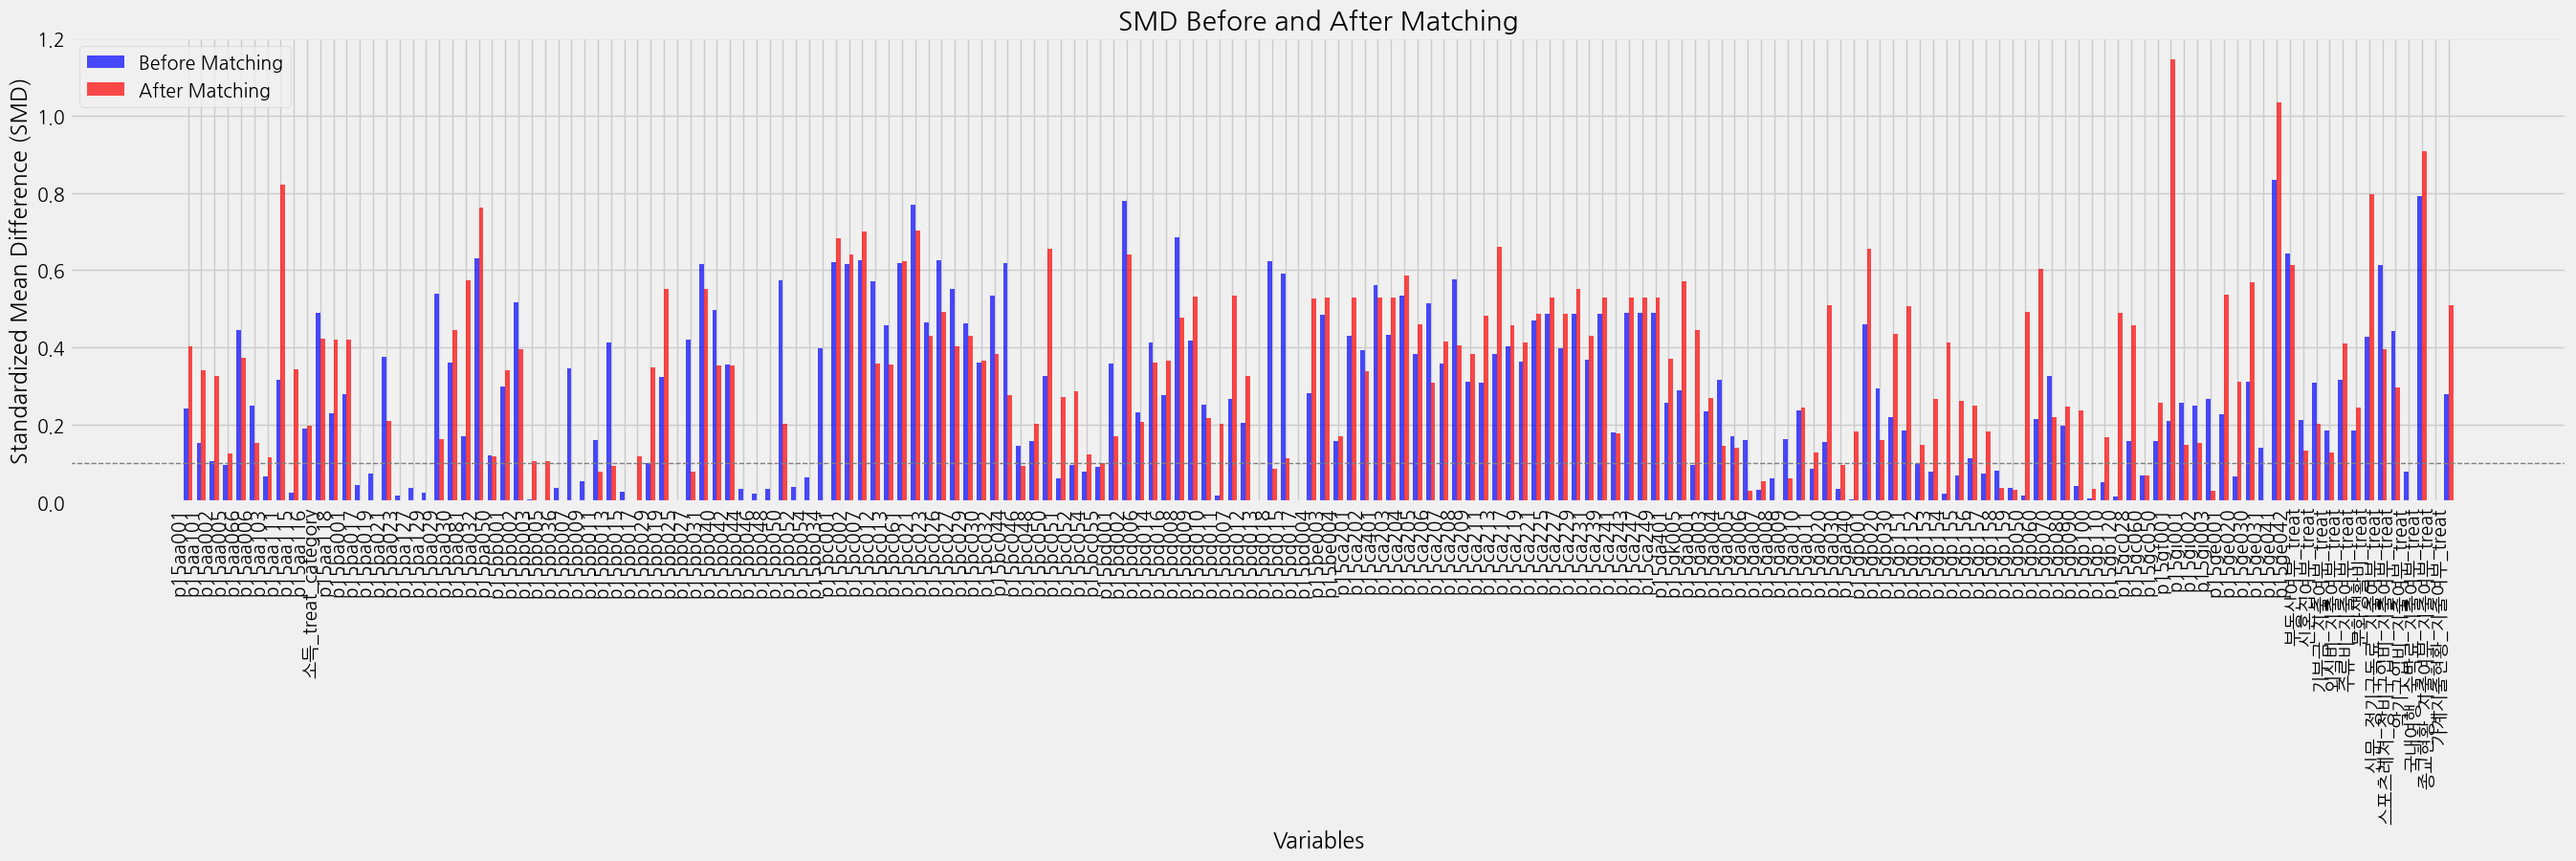

ERROR!!!!!!
##################################START##################################
Treat: 종교현황_지출여부_지출여부_treat
model fit...
matching...


0it [00:00, ?it/s]


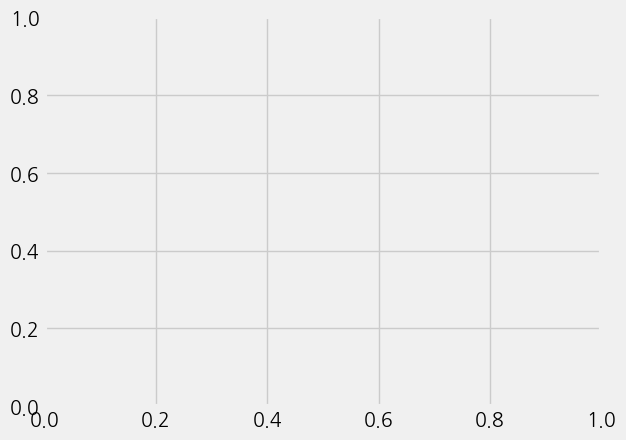

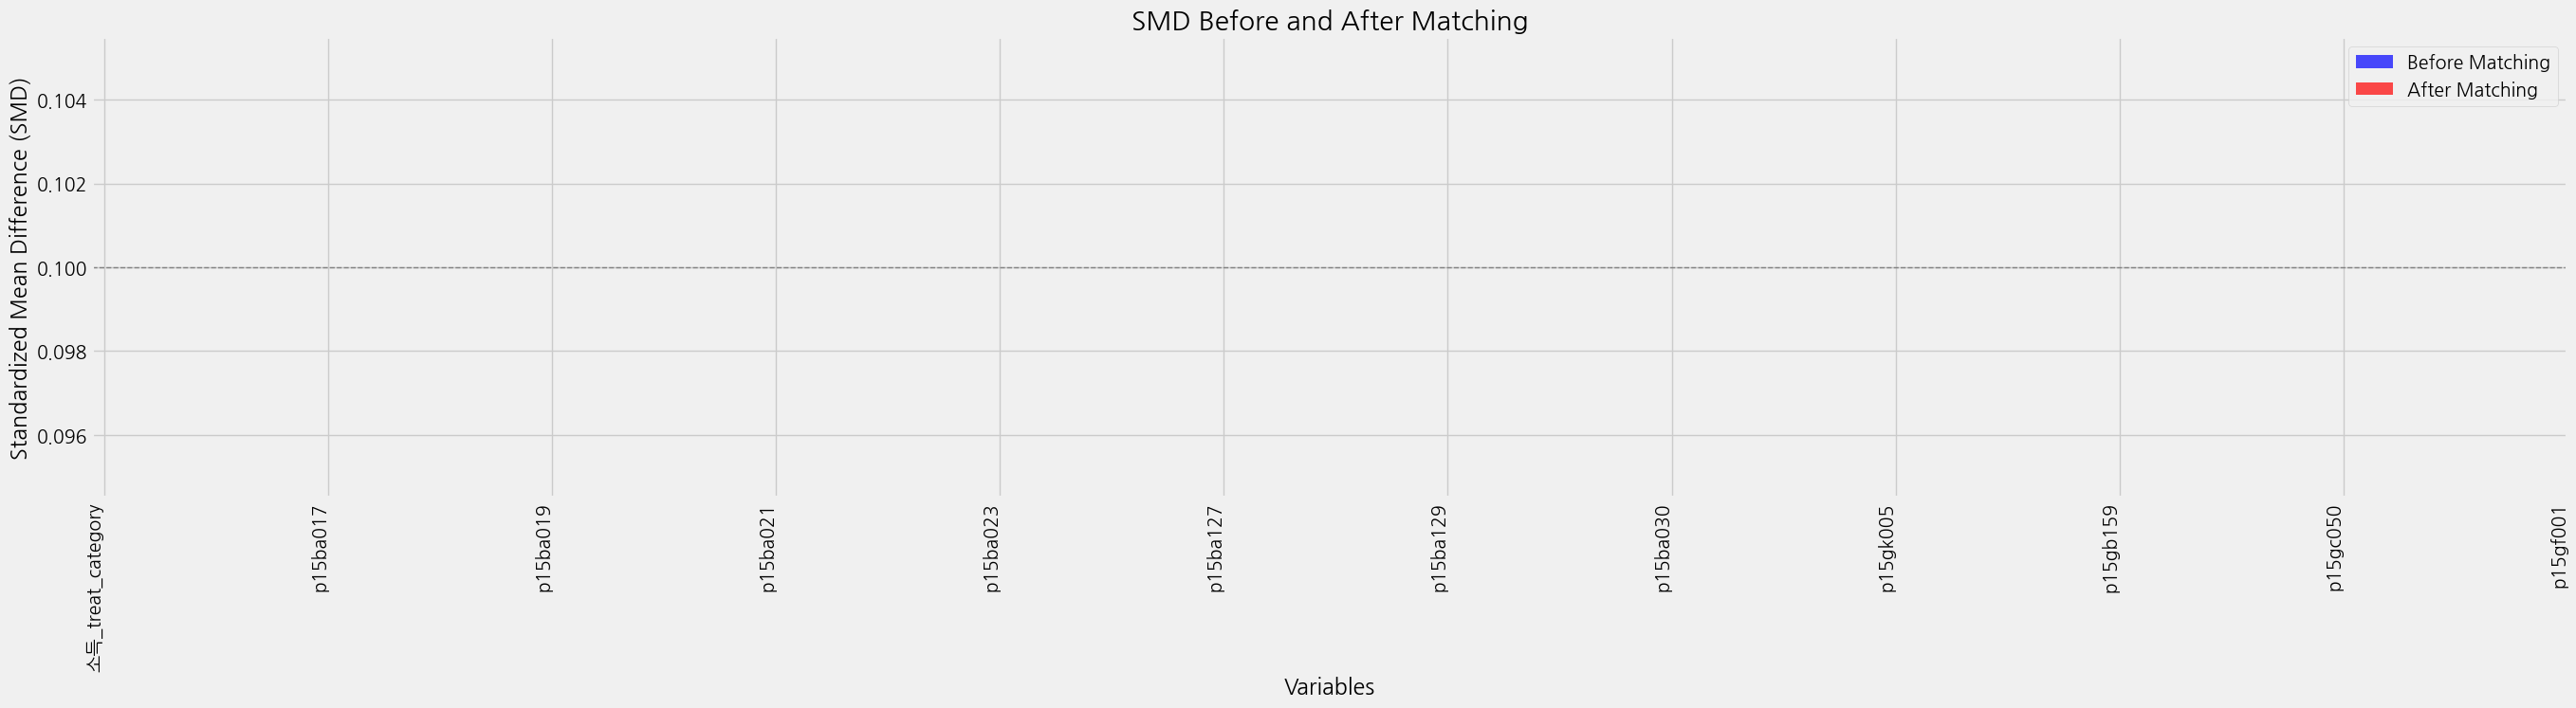

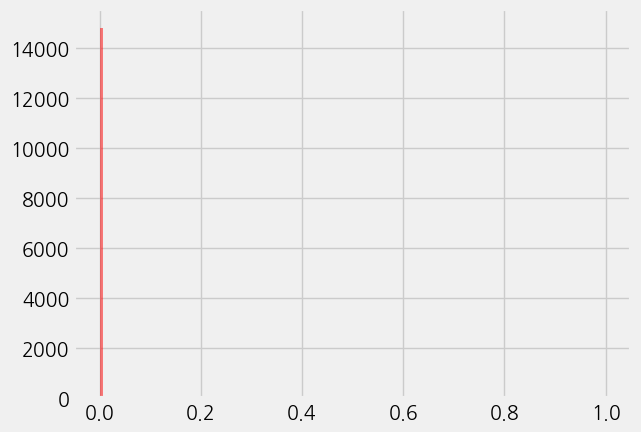

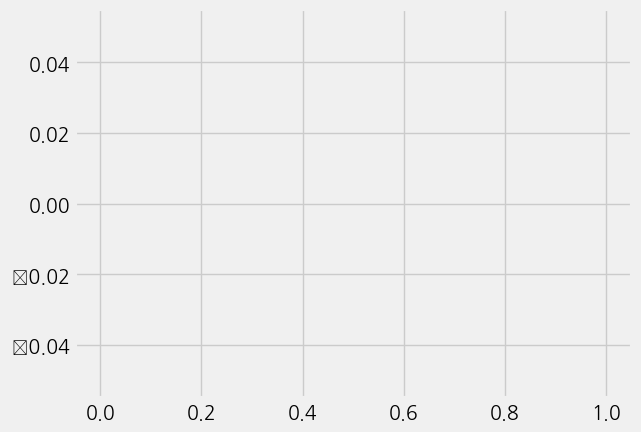

t-statistic: nan
p-value: nan
treat_group mean: nan
control_group mean: nan
###################################END###################################

##################################START##################################
Treat: 가계지출현황_지출여부_treat
model fit...
matching...


1075it [00:17, 61.73it/s]


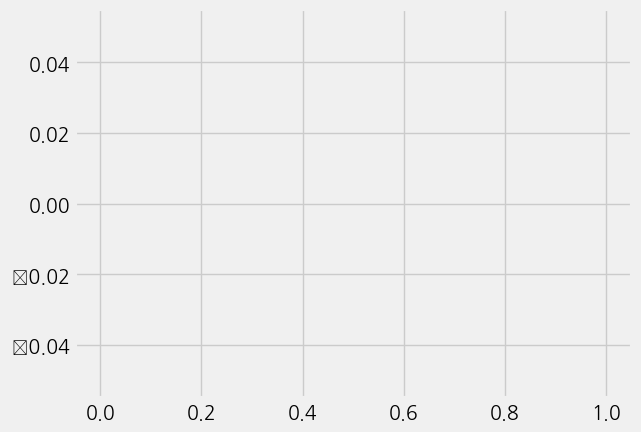

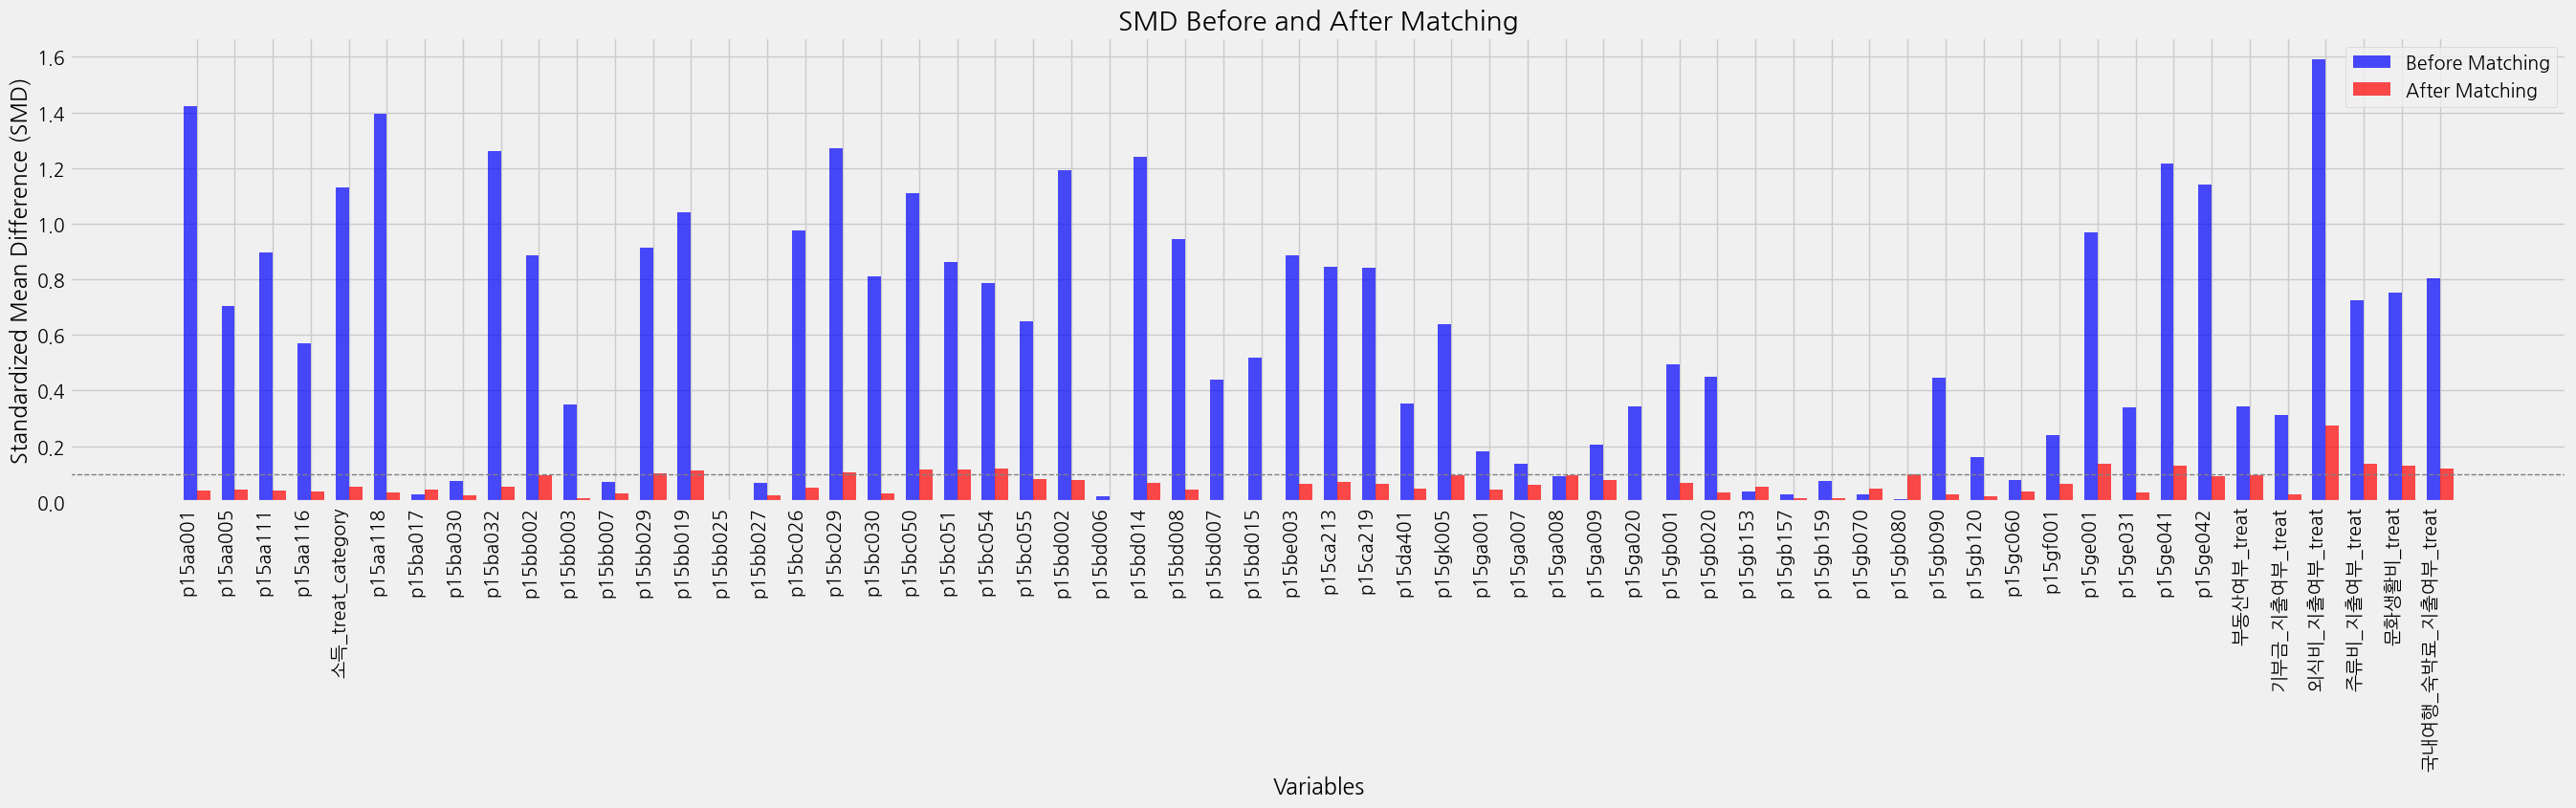

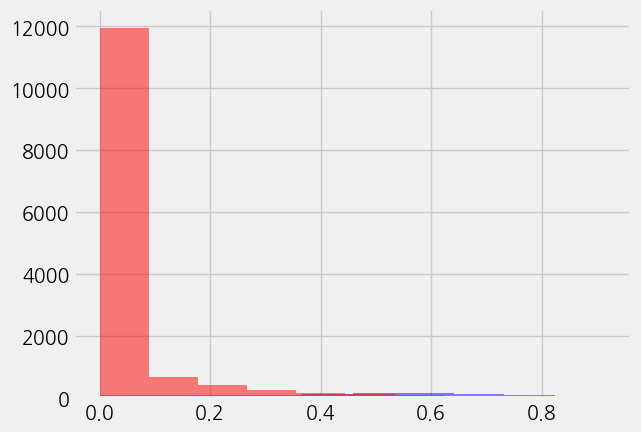

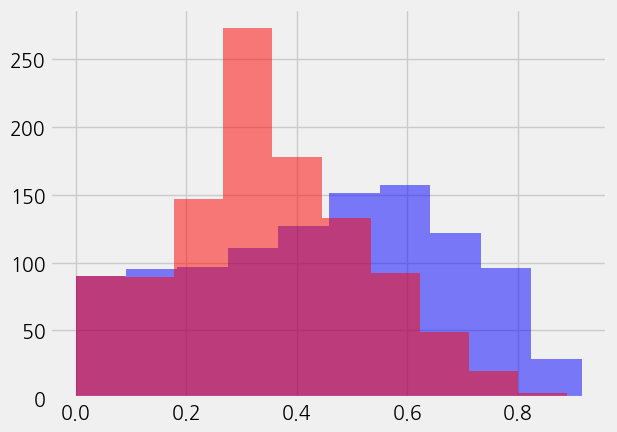

t-statistic: -2.3105879844939747
p-value: 0.020949935955700875
treat_group mean: 5.392558139534883
control_group mean: 5.595348837209302
###################################END###################################



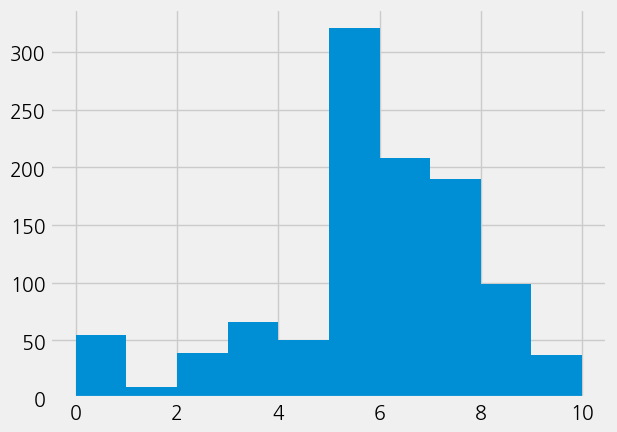

In [3]:
plt.rcParams['font.family'] = 'NanumGothic'

for TREAT in data.columns:
    if 'treat' in TREAT and 'category' not in TREAT:
        experience_df = data.copy()

        print('##################################START##################################')
        
        FEATURE = data.columns.drop([TREAT, '삶의_만족도'])
        formula = f"{TREAT} ~ {' + '.join(FEATURE)}"
        
        print("Treat:",TREAT)
        # 회귀모델 fitting
        print("model fit...")        
        
        lg_model = smf.glm(formula=formula, data=experience_df, family=sm.families.Binomial()).fit_regularized(alpha=0.001, L1_wt=0.5)
        # 회귀모델 기반 Propensity_Score 추정
        Propensity_Score = lg_model.predict(experience_df[FEATURE])
        experience_df['Propensity_Score'] = Propensity_Score
        
        # Propensity_Score 기반 매칭
        experience_df['Propensity_Score'] = pd.to_numeric(experience_df['Propensity_Score'])
        experience_df['pair'] = "NAN"
        # 처치군과 대조군 나누기
        
        treatment_group = experience_df[experience_df[TREAT] == 1]
        control_group = experience_df[experience_df[TREAT] == 0]

        if ("주류" in TREAT) or ("외식비" in TREAT):
            treatment_group = experience_df[experience_df[TREAT] == 0]
            control_group = experience_df[experience_df[TREAT] == 1]
            
        # 매칭 결과를 저장할 딕셔너리
        matching_result = {}

        # 매칭되지 않은 대조군
        remaining_controls = control_group.copy()

        print("matching...")

        try:
            for index_treat, row_treat in tqdm(treatment_group.iterrows()):
                # 처치군의 각 행에 대해서 대조군과의 유사도 측정
                distances = cdist([row_treat[['Propensity_Score']].astype(float)], remaining_controls[['Propensity_Score']], metric='euclidean')

                # 유사도가 가장 작은 대조군의 index 찾기
                best_match_index = distances.argmin()
                matching_control_index = remaining_controls.iloc[best_match_index].name
                
                # 매칭 결과 저장
                matching_result[index_treat] = matching_control_index
                
                # 매칭된 대조군 제외
                remaining_controls.drop(index=matching_control_index, inplace=True)

            for treat_index, control_index in matching_result.items():
                treatment_group.loc[treat_index, "pair"] = int(control_index)  
                control_group.loc[control_index, 'pair'] = int(treat_index) 
                
                
            matched_control_group =  control_group[control_group['pair']!="NAN"]
            unmatched_control_group = control_group[control_group['pair']=="NAN"]
            
            
            
            # lr model에서 회귀변수가 0이 된 feature는 SMD 비교에서 제외함.
            NOT_ZERO_FEATURE = []
            for key, value in (lg_model.params).items():
                if value != 0 and key != 'Intercept':
                    NOT_ZERO_FEATURE.append(key)
            
            # for SMD score
            SMD_before_matching_data = abs(treatment_group[NOT_ZERO_FEATURE].mean() - control_group[NOT_ZERO_FEATURE].mean()) / experience_df[NOT_ZERO_FEATURE].std()

            matched_data = pd.concat([treatment_group, matched_control_group])
            SMD_after_matching_data = abs(treatment_group[NOT_ZERO_FEATURE].mean() - matched_control_group[NOT_ZERO_FEATURE].mean()) / matched_data[NOT_ZERO_FEATURE].std()
            
            
            # SMD 시각화
            variables = NOT_ZERO_FEATURE
            x = np.arange(len(variables))

            # 너비 설정
            width = 0.35

            # 시각화
            fig, ax = plt.subplots(figsize=(30, 6))

            # 매칭 전 SMD
            bars1 = ax.bar(x - width/2, SMD_before_matching_data, width, label='Before Matching', color='blue', alpha=0.7)

            # 매칭 후 SMD
            bars2 = ax.bar(x + width/2, SMD_after_matching_data, width, label='After Matching', color='red', alpha=0.7)

            # 레이블 및 타이틀 설정
            ax.set_xlabel('Variables')
            ax.set_ylabel('Standardized Mean Difference (SMD)')
            ax.set_title('SMD Before and After Matching')
            ax.set_xticks(x)
            ax.set_xticklabels(variables, rotation=90, ha='right')
            ax.axhline(y=0.1, color='gray', linestyle='--', linewidth=1)
            ax.legend()


            plt.show()
            
            # Propensity_Score 분포 시각화
            plt.hist(treatment_group['Propensity_Score'], alpha=0.5, label='Treatment Group', color='blue')
            plt.hist(control_group['Propensity_Score'], alpha=0.5, label='Control Group', color='red')
            plt.show()
            
            plt.hist(treatment_group['Propensity_Score'], alpha=0.5, label='Treatment Group', color='blue')
            plt.hist(matched_control_group['Propensity_Score'], alpha=0.5, label='Control Group', color='red')
            plt.show()
            
            
            treat_group = matched_data[matched_data[TREAT] == 1]['삶의_만족도']
            control_group = matched_data[matched_data[TREAT] == 0]['삶의_만족도']

            # t-검정 수행
            t_stat, p_value = stats.ttest_ind(treat_group, control_group)

            # 결과 출력
            plt.hist(treat_group)
            print(f"t-statistic: {t_stat}")
            print(f"p-value: {p_value}")
            print("treat_group mean:", treat_group.mean())
            print("control_group mean:", control_group.mean())
            print("###################################END###################################")
            print()
        except ValueError:
            print("ERROR!!!!!!")
            pass

In [22]:
pd.set_option("display.max_columns", 100)
data[[x for x in data.columns if 'treat' in x]].describe()

,소득_treat_category,부동산여부_treat,신혼집여부_treat,기부금_지출여부_treat,외식비_지출여부_treat,주류비_지출여부_treat,문화생활비_treat,신문_정기구독료_지출여부_treat,스포츠레저_장비구입비_지출여부_treat,악기구입비_지출여부_treat,국내여행_숙박료_지출여부_treat,국외여행_숙박료_지출여부_treat,종교현황_지출여부_지출여부_treat,가계지출현황_지출여부_treat
count,14897.000000,14897.000000,14897.000000,14897.000000,14897.000000,14897.000000,14897.000000,14897.000000,14897.000000,14897.000000,14897.000000,14897.000000,14897.0,14897.000000
mean,3.616500,0.236692,0.003155,0.284621,0.909378,0.439417,0.366584,0.025643,0.038061,0.005974,0.425858,0.003289,0.0,0.072162
std,2.420404,0.425066,0.056083,0.451249,0.287081,0.496333,0.481888,0.158072,0.191351,0.077065,0.494489,0.057260,0.0,0.258765
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,5.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000
max,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


6.469020608176143


<Axes: >

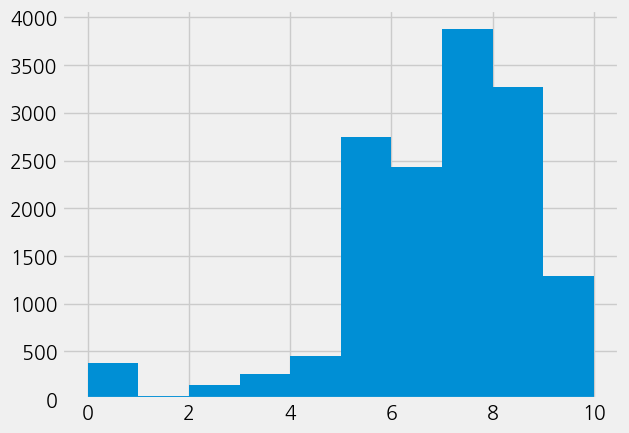

In [15]:
print(data['p15gk005'].mean())
data['p15gk005'].hist()

In [5]:
data['삶의_만족도'].mean()

6.378129824796939